In [1]:
import numpy as np 
import pandas as pd 
import torch
from data_processing import generate_vocab, process_data, create_dataloaders
from model import get_pretrained_emb, EncoderRNN, DecoderRNN, DecoderAttnRNN, EncoderDecoder, EncoderDecoderAttn
from train_eval import evaluate, train_and_eval, summarize_results, plot_single_learning_curve, load_experiment_log
import pickle as pkl 
from datetime import datetime
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# params required for generating data loaders 

SRC_LANG = 'zh'
TARG_LANG = 'en'

SRC_MAX_SENTENCE_LEN = 10
TARG_MAX_SENTENCE_LEN = 10
SRC_VOCAB_SIZE = 30000 
TARG_VOCAB_SIZE = 30000 

BATCH_SIZE = 64 

In [3]:
# takes a long time to process, save to pickle for reimport in future 
# vocab = generate_vocab(SRC_LANG, TARG_LANG, SRC_VOCAB_SIZE, TARG_VOCAB_SIZE)
# vocab_filename = "{}-{}-vocab.p".format(SRC_LANG, TARG_LANG)
# pkl.dump(vocab, open(vocab_filename, "wb"))

In [4]:
# reload from pickle 
vocab_filename = "{}-{}-vocab.p".format(SRC_LANG, TARG_LANG)
vocab = pkl.load(open(vocab_filename, "rb"))
data = process_data(SRC_LANG, TARG_LANG, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, vocab, filter_long=False)
data_minibatch = process_data(SRC_LANG, TARG_LANG, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, vocab, sample_limit=BATCH_SIZE, filter_long=False) 
data_minitrain = process_data(SRC_LANG, TARG_LANG, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, vocab, sample_limit=1000, filter_long=False)

In [5]:
# create dataloaders 
loaders_full = create_dataloaders(data, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)
loaders_minibatch = create_dataloaders(data_minibatch, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)
loaders_minitrain = create_dataloaders(data_minitrain, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)

In [6]:
# model architecture params 
NETWORK_TYPE = 'rnn'
RNN_CELL_TYPE = 'gru'
NUM_LAYERS = 2 
ENC_HIDDEN_DIM = 512
DEC_HIDDEN_DIM = 2 * ENC_HIDDEN_DIM 
TEACHER_FORCING_RATIO = 1
CLIP_GRAD_MAX_NORM = 1
ENC_DROPOUT = 0 
DEC_DROPOUT = 0  
ATTENTION_TYPE = 'additive'

# training params  
NUM_EPOCHS = 10 
LR = 0.00015 
OPTIMIZER = 'Adam'
LAZY_TRAIN = False

# name the model and experiment 
if NETWORK_TYPE == 'rnn': 
    EXPERIMENT_NAME = '{}-rnn-{}-attn'.format(SRC_LANG, ATTENTION_TYPE)
elif NETWORK_TYPE == 'cnn': 
    EXPERIMENT_NAME = '{}-cnn'.format(SRC_LANG)
MODEL_NAME = '{}-{}'.format(EXPERIMENT_NAME, datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

In [7]:
# store as dict to save to results later 
params = {'experiment_name': EXPERIMENT_NAME,'model_name': MODEL_NAME, 'src_lang': SRC_LANG, 'targ_lang': TARG_LANG, 
          'rnn_cell_type': RNN_CELL_TYPE, 'src_max_sentence_len': SRC_MAX_SENTENCE_LEN, 
          'targ_max_sentence_len': TARG_MAX_SENTENCE_LEN, 'src_vocab_size': SRC_VOCAB_SIZE, 
          'targ_vocab_size': TARG_VOCAB_SIZE, 'num_layers': NUM_LAYERS, 'enc_hidden_dim': ENC_HIDDEN_DIM, 
          'dec_hidden_dim': DEC_HIDDEN_DIM, 'teacher_forcing_ratio': TEACHER_FORCING_RATIO, 
          'clip_grad_max_norm': CLIP_GRAD_MAX_NORM, 'enc_dropout': ENC_DROPOUT, 'dec_dropout': DEC_DROPOUT, 
          'attention_type': ATTENTION_TYPE, 'batch_size': BATCH_SIZE, 'num_epochs': NUM_EPOCHS, 
          'learning_rate': LR, 'optimizer': OPTIMIZER, 'lazy_train': LAZY_TRAIN} 

In [8]:
# define model 

encoder = EncoderRNN(rnn_cell_type=RNN_CELL_TYPE, enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS, 
                     src_max_sentence_len=SRC_MAX_SENTENCE_LEN, enc_dropout=ENC_DROPOUT, 
                     pretrained_word2vec=get_pretrained_emb(vocab[SRC_LANG]['word2vec'], vocab[SRC_LANG]['token2id']))

if ATTENTION_TYPE == 'without': 
    # without attention 
    decoder = DecoderRNN(dec_hidden_dim=DEC_HIDDEN_DIM, enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS,
                         targ_vocab_size=TARG_VOCAB_SIZE, targ_max_sentence_len=TARG_MAX_SENTENCE_LEN, 
                         pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], 
                                                                vocab[TARG_LANG]['token2id']))
    model = EncoderDecoder(encoder, decoder, vocab[TARG_LANG]['token2id']).to(device)
    
else: 
    # with attention 
    decoder = DecoderAttnRNN(rnn_cell_type=RNN_CELL_TYPE, dec_hidden_dim=DEC_HIDDEN_DIM, enc_hidden_dim=ENC_HIDDEN_DIM, 
                             num_layers=NUM_LAYERS, targ_vocab_size=TARG_VOCAB_SIZE, 
                             src_max_sentence_len=SRC_MAX_SENTENCE_LEN, targ_max_sentence_len=TARG_MAX_SENTENCE_LEN, 
                             dec_dropout=DEC_DROPOUT, attention_type=ATTENTION_TYPE,
                             pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], 
                                                                    vocab[TARG_LANG]['token2id']))
    model = EncoderDecoderAttn(encoder, decoder, vocab[TARG_LANG]['token2id']).to(device) 

In [9]:
model, results = train_and_eval(
    model=model, loaders_full=loaders_full, loaders_minibatch=loaders_minibatch, loaders_minitrain=loaders_minitrain, 
    params=params, vocab=vocab, print_intermediate=500, save_checkpoint=True, save_to_log=True, 
    lazy_eval=True, print_attn=True, inspect_samples=2)

Epoch: 0.00, Train Loss: 0.00, Val Loss: 10.19, Train BLEU: 0.00, Val BLEU: 0.02, Minutes Elapsed: 0.12
Sampling from val predictions...
Source: 当 她们 走出 矿井 时 全身 <UNK> <EOS> <PAD> <PAD>
Reference: when they came out of the shaft , they
Model: <SOS> we the the the the the the the the
Attention Weights: tensor([[0.1055, 0.1135, 0.1191, 0.1235, 0.1271, 0.1309, 0.1390, 0.1413, 0.0000,
         0.0000],
        [0.1054, 0.1136, 0.1192, 0.1237, 0.1272, 0.1308, 0.1388, 0.1412, 0.0000,
         0.0000],
        [0.1055, 0.1137, 0.1193, 0.1238, 0.1273, 0.1308, 0.1387, 0.1410, 0.0000,
         0.0000],
        [0.1055, 0.1137, 0.1194, 0.1238, 0.1273, 0.1308, 0.1386, 0.1409, 0.0000,
         0.0000],
        [0.1054, 0.1137, 0.1194, 0.1238, 0.1274, 0.1308, 0.1386, 0.1408, 0.0000,
         0.0000],
        [0.1054, 0.1137, 0.1194, 0.1239, 0.1274, 0.1309, 0.1386, 0.1408, 0.0000,
         0.0000],
        [0.1054, 0.1137, 0.1194, 0.1239, 0.1274, 0.1309, 0.1386, 0.1408, 0.0000,
         0.0000],
     

Epoch: 0.15, Train Loss: 0.00, Val Loss: 6.09, Train BLEU: 0.00, Val BLEU: 3.09, Minutes Elapsed: 11.59
Sampling from val predictions...
Source: 所以 我们 做 的 是 把 这些 光子 送进 <UNK>
Reference: so , what we do is we send that
Model: <SOS> and &apos;s , , , , , , <EOS>
Attention Weights: tensor([[2.7160e-04, 9.5680e-03, 1.2979e-01, 3.6054e-01, 3.5372e-01, 1.3080e-01,
         1.4057e-02, 1.1522e-03, 9.6778e-05, 3.4403e-06],
        [5.2004e-03, 4.1515e-02, 1.9378e-01, 3.3366e-01, 2.8401e-01, 1.1798e-01,
         2.0304e-02, 3.0078e-03, 4.8398e-04, 5.1066e-05],
        [9.1988e-03, 5.3768e-02, 1.9588e-01, 3.1063e-01, 2.7033e-01, 1.2683e-01,
         2.7439e-02, 4.9392e-03, 8.9036e-04, 9.7347e-05],
        [3.5973e-03, 3.1496e-02, 1.5299e-01, 3.0042e-01, 3.0320e-01, 1.6220e-01,
         3.8657e-02, 6.5667e-03, 8.3838e-04, 3.6333e-05],
        [1.0762e-03, 1.7100e-02, 1.2479e-01, 2.9882e-01, 3.2750e-01, 1.7960e-01,
         4.2663e-02, 7.4533e-03, 9.6000e-04, 2.8844e-05],
        [5.5979e-04, 1.242

Epoch: 0.30, Train Loss: 0.00, Val Loss: 5.96, Train BLEU: 0.00, Val BLEU: 4.08, Minutes Elapsed: 22.90
Sampling from val predictions...
Source: 因为 我 的 家人 不 懂 中文 所以 我 得
Reference: since my family couldn &apos;t speak chinese , i
Model: <SOS> and , , , , the to you .
Attention Weights: tensor([[4.4054e-07, 2.8611e-07, 4.6611e-07, 1.9134e-06, 8.0812e-07, 1.1240e-06,
         4.1567e-06, 2.9040e-05, 8.4442e-03, 9.9152e-01],
        [3.4582e-06, 2.0243e-06, 2.8321e-06, 8.2715e-06, 4.1686e-06, 5.4247e-06,
         1.4821e-05, 6.5417e-05, 7.8933e-03, 9.9200e-01],
        [1.0757e-06, 7.3076e-07, 9.7131e-07, 2.4252e-06, 1.4228e-06, 1.9047e-06,
         5.1795e-06, 3.0132e-05, 5.7557e-03, 9.9420e-01],
        [6.2391e-07, 3.8020e-07, 5.2454e-07, 1.4449e-06, 7.9848e-07, 1.1010e-06,
         3.2980e-06, 2.1118e-05, 4.9165e-03, 9.9505e-01],
        [4.3418e-06, 3.2874e-06, 4.1031e-06, 7.7241e-06, 5.6632e-06, 7.2806e-06,
         1.6164e-05, 7.2017e-05, 6.8402e-03, 9.9304e-01],
        [1.4373e-06

Epoch: 0.45, Train Loss: 0.00, Val Loss: 5.82, Train BLEU: 0.00, Val BLEU: 3.55, Minutes Elapsed: 34.24
Sampling from val predictions...
Source: 当时 我 在 一家 意大利 大利 非政府 政府 组织 织工
Reference: i worked for an italian ngo , and every
Model: <SOS> and , to the , of , and ,
Attention Weights: tensor([[1.3582e-08, 4.1250e-08, 3.1295e-08, 1.5284e-08, 3.0145e-08, 1.0146e-07,
         1.2612e-06, 3.2946e-05, 1.0124e-02, 9.8984e-01],
        [1.6702e-07, 2.0980e-07, 1.9607e-07, 1.4239e-07, 2.1631e-07, 4.2088e-07,
         2.9444e-06, 3.5646e-05, 8.2489e-03, 9.9171e-01],
        [2.3452e-08, 1.4754e-08, 1.9653e-08, 4.3815e-08, 1.3707e-07, 1.7796e-07,
         2.0933e-06, 1.5247e-05, 5.4209e-03, 9.9456e-01],
        [2.0645e-05, 1.3555e-05, 1.6976e-05, 2.9749e-05, 5.4757e-05, 5.9961e-05,
         1.8616e-04, 4.1865e-04, 1.2067e-02, 9.8713e-01],
        [1.5076e-08, 1.3106e-08, 1.6473e-08, 2.8020e-08, 7.7820e-08, 1.0810e-07,
         1.2114e-06, 1.0618e-05, 4.2355e-03, 9.9575e-01],
        [8.3683e-10, 

Epoch: 0.60, Train Loss: 0.00, Val Loss: 5.70, Train BLEU: 0.00, Val BLEU: 2.41, Minutes Elapsed: 45.69
Sampling from val predictions...
Source: 我们 必须 学会 如何 让 这些 人 给出 他们 的
Reference: you have to learn how to get these people
Model: <SOS> we we to to , , , , ,
Attention Weights: tensor([[7.8018e-08, 2.9161e-08, 3.6094e-08, 7.9847e-08, 7.2599e-08, 1.5760e-06,
         5.8680e-06, 9.4273e-04, 3.9506e-02, 9.5954e-01],
        [1.6530e-09, 1.1693e-09, 1.5521e-09, 3.3913e-09, 3.2982e-09, 5.7271e-08,
         6.1783e-07, 1.1071e-04, 1.4204e-02, 9.8568e-01],
        [1.0833e-07, 9.9222e-08, 1.1643e-07, 1.7351e-07, 1.6870e-07, 7.1629e-07,
         3.0248e-06, 9.1374e-05, 7.3216e-03, 9.9258e-01],
        [5.1667e-05, 5.0147e-05, 5.3548e-05, 6.2498e-05, 6.4144e-05, 1.1539e-04,
         2.3064e-04, 1.2757e-03, 1.9889e-02, 9.7821e-01],
        [1.2911e-07, 1.2924e-07, 1.4885e-07, 2.0272e-07, 2.5869e-07, 8.4571e-07,
         4.2604e-06, 1.1209e-04, 8.6903e-03, 9.9119e-01],
        [1.2819e-07, 1.283

Epoch: 0.75, Train Loss: 0.00, Val Loss: 5.61, Train BLEU: 0.00, Val BLEU: 4.71, Minutes Elapsed: 57.32
Sampling from val predictions...
Source: 他 只是 压力 太大 了 婚礼 的 筹备 和 我家
Reference: he had just been really stressed out by the
Model: <SOS> he he , to , , , the the
Attention Weights: tensor([[1.0155e-06, 6.8017e-08, 9.8219e-09, 1.7654e-07, 7.7478e-07, 2.8095e-07,
         1.2127e-05, 5.3829e-05, 8.4906e-03, 9.9144e-01],
        [2.6017e-05, 1.9954e-05, 7.6429e-06, 6.8833e-05, 7.2266e-05, 6.9320e-05,
         5.2356e-04, 1.7828e-03, 3.5026e-02, 9.6240e-01],
        [2.5754e-06, 5.2077e-06, 6.6491e-06, 3.7527e-05, 3.3509e-05, 9.6709e-05,
         4.3305e-04, 2.4746e-03, 4.1193e-02, 9.5572e-01],
        [7.2178e-06, 1.1811e-05, 1.4734e-05, 4.9187e-05, 3.5536e-05, 8.9986e-05,
         2.6905e-04, 1.5497e-03, 2.7827e-02, 9.7015e-01],
        [2.0789e-06, 4.2658e-06, 5.7409e-06, 1.5129e-05, 1.3002e-05, 3.0318e-05,
         9.5399e-05, 5.2374e-04, 1.5100e-02, 9.8421e-01],
        [1.7485e-06, 3

Epoch: 0.90, Train Loss: 0.00, Val Loss: 5.50, Train BLEU: 0.00, Val BLEU: 3.42, Minutes Elapsed: 68.81
Sampling from val predictions...
Source: 我 以为 我 这辈子 辈子 完 了 尽管 尽管如此 如此
Reference: i thought my life was over , but i
Model: <SOS> i you to you , , to , ,
Attention Weights: tensor([[8.9659e-01, 1.4466e-08, 1.0303e-01, 9.5535e-09, 1.8258e-07, 1.2429e-06,
         3.7815e-07, 4.1452e-07, 1.5702e-06, 3.7796e-04],
        [7.7430e-01, 1.8426e-05, 2.1986e-01, 1.0759e-06, 1.2329e-05, 5.5734e-05,
         2.2860e-05, 3.0927e-05, 1.2426e-04, 5.5714e-03],
        [1.0220e-01, 6.7249e-03, 3.7458e-01, 8.2413e-03, 3.8505e-02, 6.6947e-02,
         4.0325e-02, 4.6725e-02, 6.7465e-02, 2.4829e-01],
        [5.5426e-03, 5.0637e-04, 3.4657e-01, 1.6419e-03, 1.5198e-02, 4.0256e-02,
         1.7617e-02, 2.1832e-02, 3.7730e-02, 5.1310e-01],
        [6.3685e-03, 4.3698e-04, 2.6056e-01, 8.4741e-04, 1.3391e-02, 4.5219e-02,
         1.9062e-02, 2.4173e-02, 4.8134e-02, 5.8181e-01],
        [8.9782e-04, 1.0600e-

Epoch: 1.00, Train Loss: 0.00, Val Loss: 5.43, Train BLEU: 0.00, Val BLEU: 5.31, Minutes Elapsed: 76.58
Sampling from val predictions...
Source: 在 学校 我们 用 很多 时间 来 学习 <UNK> <UNK>
Reference: in school , we spent a lot of time
Model: <SOS> and &apos;s , we we to to of .
Attention Weights: tensor([[7.5371e-08, 1.3289e-07, 9.9176e-01, 4.8311e-07, 1.0595e-07, 2.6158e-07,
         2.8969e-04, 1.9300e-03, 3.2203e-03, 2.8008e-03],
        [6.9118e-06, 1.4951e-05, 9.3952e-01, 3.8328e-05, 2.1801e-06, 8.8145e-06,
         3.7943e-03, 1.2993e-02, 2.2975e-02, 2.0649e-02],
        [8.9688e-03, 1.3426e-02, 2.8846e-01, 4.4219e-02, 3.2606e-02, 4.0176e-02,
         1.7746e-01, 1.7160e-01, 1.1490e-01, 1.0819e-01],
        [1.4783e-03, 2.4828e-03, 5.6738e-01, 1.6287e-02, 1.2129e-02, 1.5678e-02,
         1.3559e-01, 1.2606e-01, 6.5093e-02, 5.7821e-02],
        [1.7543e-03, 2.7977e-03, 9.5578e-02, 2.9050e-02, 2.1478e-02, 3.6413e-02,
         2.8094e-01, 2.5075e-01, 1.4395e-01, 1.3729e-01],
        [2.2484e-0

Epoch: 1.15, Train Loss: 0.00, Val Loss: 5.39, Train BLEU: 0.00, Val BLEU: 4.71, Minutes Elapsed: 88.09
Sampling from val predictions...
Source: 但是 很多 尝试 <UNK> 的 人 死 了 <EOS> <PAD>
Reference: but many die . <EOS> <PAD> <PAD> <PAD> <PAD>
Model: <SOS> but , &apos;s , , &apos;s . . .
Attention Weights: tensor([[0.0000, 0.0000, 0.0001, 0.0000, 0.0000, 0.0000, 0.0020, 0.9755, 0.0223,
         0.0000],
        [0.0000, 0.0000, 0.0003, 0.0001, 0.0001, 0.0001, 0.0092, 0.9284, 0.0618,
         0.0000],
        [0.0033, 0.0266, 0.0556, 0.0254, 0.0261, 0.0245, 0.1694, 0.4601, 0.2088,
         0.0000],
        [0.0127, 0.0526, 0.0842, 0.0358, 0.0454, 0.0433, 0.1742, 0.3600, 0.1918,
         0.0000],
        [0.0160, 0.0495, 0.0761, 0.0485, 0.0572, 0.0539, 0.1760, 0.3438, 0.1790,
         0.0000],
        [0.0224, 0.0608, 0.0925, 0.0679, 0.0794, 0.0771, 0.1724, 0.2781, 0.1493,
         0.0000],
        [0.0398, 0.0722, 0.0925, 0.0690, 0.0887, 0.0910, 0.1594, 0.2251, 0.1623,
         0.0000],
       

Epoch: 1.30, Train Loss: 0.00, Val Loss: 5.36, Train BLEU: 0.00, Val BLEU: 5.04, Minutes Elapsed: 99.69
Sampling from val predictions...
Source: 我 本 以为 只有 我们 意大利 意大利人 大利 利人 在
Reference: i thought it was only us italians <UNK> around
Model: <SOS> i i , &quot; us to of we the
Attention Weights: tensor([[9.9995e-01, 1.5231e-12, 4.4855e-09, 1.2084e-08, 4.4111e-05, 6.9583e-10,
         5.1692e-10, 2.0121e-09, 9.7176e-10, 2.8546e-06],
        [9.9727e-01, 5.7783e-08, 2.9343e-05, 3.5427e-05, 2.0729e-03, 6.2201e-06,
         4.9176e-06, 9.9952e-06, 8.4019e-06, 5.6425e-04],
        [5.7734e-02, 3.2463e-04, 9.0769e-02, 6.7556e-02, 6.3662e-01, 7.7935e-03,
         6.3610e-03, 1.3137e-02, 8.0745e-03, 1.1163e-01],
        [1.4660e-02, 5.0055e-05, 3.7889e-02, 4.7404e-02, 7.7907e-01, 5.1163e-03,
         4.1942e-03, 1.0120e-02, 4.7430e-03, 9.6757e-02],
        [2.4541e-02, 4.8402e-05, 2.4100e-02, 5.3274e-02, 5.4549e-01, 7.2307e-03,
         5.8467e-03, 2.0565e-02, 1.1407e-02, 3.0750e-01],
        [5.

Epoch: 1.45, Train Loss: 0.00, Val Loss: 5.31, Train BLEU: 0.00, Val BLEU: 5.24, Minutes Elapsed: 111.25
Sampling from val predictions...
Source: 这些 迹象 表明 如果 我们 能 有 一个 表达 自己
Reference: together , we &apos;ve shown how powerful our public
Model: <SOS> and &apos;s the , to to that we ,
Attention Weights: tensor([[2.0491e-05, 1.0613e-07, 1.1198e-05, 3.4705e-05, 9.8453e-01, 1.8271e-06,
         6.1058e-06, 2.7894e-06, 2.0471e-04, 1.5185e-02],
        [8.6773e-03, 5.1405e-04, 7.8968e-03, 1.2758e-02, 6.8429e-01, 2.1533e-03,
         4.8214e-03, 3.0143e-03, 2.8777e-02, 2.4710e-01],
        [5.1677e-02, 2.5833e-02, 8.8497e-02, 7.9895e-02, 2.4242e-01, 2.9187e-02,
         4.3621e-02, 2.8329e-02, 1.0272e-01, 3.0782e-01],
        [5.9387e-03, 2.0172e-03, 3.3737e-02, 4.8688e-02, 6.2109e-01, 4.5652e-03,
         8.5845e-03, 5.0759e-03, 4.0734e-02, 2.2957e-01],
        [1.3331e-02, 1.0575e-02, 7.6570e-02, 9.4447e-02, 2.5589e-01, 4.0740e-02,
         5.3660e-02, 3.2431e-02, 1.0053e-01, 3.2183e-01],
 

Epoch: 1.60, Train Loss: 0.00, Val Loss: 5.25, Train BLEU: 0.00, Val BLEU: 4.29, Minutes Elapsed: 122.36
Sampling from val predictions...
Source: 现在 我们 重建 建基 基督 <UNK> 新西兰 西兰 却 不知
Reference: so now you &apos;re rebuilding christchurch without knowing what
Model: <SOS> now we we we to to , , ,
Attention Weights: tensor([[2.2459e-07, 9.5433e-01, 3.1192e-07, 1.2685e-06, 1.0553e-05, 3.7570e-05,
         6.0188e-06, 6.5718e-05, 6.9777e-04, 4.4846e-02],
        [5.9297e-06, 9.9765e-01, 7.5348e-07, 2.5335e-06, 2.9389e-05, 6.5956e-05,
         8.6488e-06, 6.1178e-05, 2.9384e-04, 1.8833e-03],
        [8.4376e-03, 2.8113e-01, 1.7634e-02, 1.7513e-02, 4.9444e-02, 5.2958e-02,
         1.6654e-02, 5.1721e-02, 1.2956e-01, 3.7495e-01],
        [7.3122e-03, 1.5012e-01, 3.0620e-02, 2.7908e-02, 6.7448e-02, 6.1167e-02,
         2.0554e-02, 5.6224e-02, 1.4105e-01, 4.3760e-01],
        [3.4595e-03, 1.2857e-01, 1.4622e-02, 1.6855e-02, 6.2094e-02, 5.1620e-02,
         1.4254e-02, 5.2358e-02, 1.5219e-01, 5.0397

Epoch: 1.75, Train Loss: 0.00, Val Loss: 5.24, Train BLEU: 0.00, Val BLEU: 5.95, Minutes Elapsed: 133.66
Sampling from val predictions...
Source: 在 50 <UNK> 摄氏 摄氏度 的 高温 中 男人 女人
Reference: enveloped in temperatures of 130 degrees , men ,
Model: <SOS> in , <UNK> , , , the the &apos;s
Attention Weights: tensor([[6.8866e-08, 1.1563e-03, 1.6898e-05, 1.4592e-05, 9.9833e-04, 8.9488e-05,
         4.7320e-05, 7.6496e-03, 5.1152e-04, 9.8952e-01],
        [6.6058e-05, 1.0262e-01, 2.3977e-03, 2.3465e-03, 3.1472e-02, 3.1150e-03,
         1.9614e-03, 3.7325e-02, 5.9935e-03, 8.1270e-01],
        [1.6583e-03, 5.5056e-02, 1.0848e-02, 3.0023e-02, 1.0498e-01, 4.9428e-02,
         2.6654e-02, 1.2270e-01, 4.7901e-02, 5.5075e-01],
        [2.3374e-05, 4.6200e-03, 3.3065e-04, 2.2965e-03, 2.8598e-02, 1.8654e-02,
         7.4795e-03, 1.5681e-01, 1.8220e-02, 7.6297e-01],
        [1.0395e-04, 3.5113e-03, 5.1684e-04, 3.9682e-03, 4.1806e-02, 5.1388e-02,
         2.1240e-02, 2.0124e-01, 2.9737e-02, 6.4649e-01],
   

Epoch: 1.90, Train Loss: 0.00, Val Loss: 5.17, Train BLEU: 0.00, Val BLEU: 5.35, Minutes Elapsed: 145.05
Sampling from val predictions...
Source: 在 加德 <UNK> 我 由 一些 从前 是 性 奴
Reference: in kathmandu , i was escorted by women who
Model: <SOS> in the , i was a to the ,
Attention Weights: tensor([[1.1067e-09, 3.7363e-08, 2.6466e-07, 9.9280e-01, 2.7671e-07, 2.9366e-07,
         8.0772e-07, 1.1544e-06, 8.1725e-06, 7.1852e-03],
        [1.6210e-05, 4.2082e-04, 7.0285e-04, 9.5823e-01, 3.5047e-04, 2.0813e-04,
         3.8725e-04, 5.0079e-04, 1.8378e-03, 3.7344e-02],
        [1.7276e-03, 1.2257e-02, 1.4741e-02, 3.9285e-01, 3.7639e-02, 1.4026e-02,
         1.8072e-02, 2.4218e-02, 5.9835e-02, 4.2464e-01],
        [1.7413e-04, 9.4521e-04, 1.5754e-03, 8.3058e-01, 1.4808e-02, 5.7334e-03,
         6.2077e-03, 5.9489e-03, 1.4361e-02, 1.1967e-01],
        [1.1243e-04, 9.3563e-04, 1.6332e-03, 7.7670e-01, 5.2184e-03, 1.9755e-03,
         3.6967e-03, 4.4319e-03, 1.6064e-02, 1.8923e-01],
        [3.4439e-04,

Epoch: 2.00, Train Loss: 0.00, Val Loss: 5.17, Train BLEU: 0.00, Val BLEU: 5.67, Minutes Elapsed: 152.78
Sampling from val predictions...
Source: 但是 狮子 十分 聪明 <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: but lions are very clever . <EOS> <PAD> <PAD>
Model: <SOS> but it &apos;s &apos;t . . <EOS> <EOS> <EOS>
Attention Weights: tensor([[0.0000, 0.0000, 0.0008, 0.0770, 0.9222, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0004, 0.0073, 0.2009, 0.4403, 0.3511, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0190, 0.0678, 0.2385, 0.3367, 0.3379, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0294, 0.0734, 0.2456, 0.3088, 0.3429, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0391, 0.0893, 0.2866, 0.3006, 0.2843, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0436, 0.0987, 0.2611, 0.2885, 0.3082, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0132, 0.0512, 0.2380, 0.3287, 0.3688, 0.0000, 0.0000, 0.0000, 0.000

Epoch: 2.15, Train Loss: 0.00, Val Loss: 5.17, Train BLEU: 0.00, Val BLEU: 5.41, Minutes Elapsed: 164.28
Sampling from val predictions...
Source: 我 当时 也 不知 知道 第二 第二步 二步 是 孤立
Reference: i also didn &apos;t know that the second step
Model: <SOS> i i that to know to the was is
Attention Weights: tensor([[9.9885e-01, 1.7672e-09, 3.2112e-07, 1.5083e-08, 1.5470e-06, 3.9712e-07,
         1.4399e-06, 5.9101e-06, 2.1339e-06, 1.1381e-03],
        [9.8631e-01, 1.7709e-04, 1.5834e-03, 1.4885e-04, 7.7589e-04, 2.7866e-04,
         4.3470e-04, 8.4570e-04, 6.5842e-04, 8.7886e-03],
        [9.3935e-02, 1.5041e-02, 2.2175e-01, 5.4701e-03, 3.7882e-02, 9.5533e-03,
         1.6323e-02, 2.7633e-02, 2.4203e-02, 5.4821e-01],
        [9.0686e-03, 6.6330e-03, 1.8853e-01, 1.2342e-02, 1.1505e-01, 2.9408e-02,
         4.3598e-02, 6.3389e-02, 4.7344e-02, 4.8464e-01],
        [3.9329e-03, 1.9489e-03, 1.1563e-01, 1.5606e-02, 1.6909e-01, 3.9402e-02,
         5.6267e-02, 9.4569e-02, 5.5416e-02, 4.4814e-01],
        [8.

Epoch: 2.30, Train Loss: 0.00, Val Loss: 5.15, Train BLEU: 0.00, Val BLEU: 6.51, Minutes Elapsed: 175.77
Sampling from val predictions...
Source: 这些 女孩 是 幸运 的 <EOS> <PAD> <PAD> <PAD> <PAD>
Reference: these girls were so lucky . <EOS> <PAD> <PAD>
Model: <SOS> these is are . . . <EOS> <EOS> .
Attention Weights: tensor([[0.2140, 0.0001, 0.0042, 0.0042, 0.6445, 0.1331, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.4846, 0.0270, 0.1181, 0.0483, 0.2151, 0.1070, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.2264, 0.0626, 0.2228, 0.0860, 0.2276, 0.1747, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0595, 0.0592, 0.2591, 0.1862, 0.2969, 0.1391, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0918, 0.0766, 0.1877, 0.1905, 0.2747, 0.1786, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0767, 0.0568, 0.1502, 0.2017, 0.3060, 0.2086, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0783, 0.0714, 0.1246, 0.2162, 0.2689, 0.2405, 0.0000, 0.0000, 0.0000,
         0.000

Epoch: 2.45, Train Loss: 0.00, Val Loss: 5.12, Train BLEU: 0.00, Val BLEU: 6.18, Minutes Elapsed: 187.38
Sampling from val predictions...
Source: 有人 指控 我 是 朝鲜 <UNK> 所以 警察 测试 了
Reference: someone had accused me of being north korean ,
Model: <SOS> and , , , i but , , ,
Attention Weights: tensor([[2.0840e-10, 1.7978e-10, 9.9996e-01, 3.3520e-09, 2.6003e-07, 4.8832e-07,
         4.1267e-06, 2.2833e-07, 8.1823e-08, 3.7690e-05],
        [7.4979e-06, 7.5890e-06, 9.9398e-01, 7.2398e-05, 4.8550e-04, 6.3708e-04,
         1.5934e-03, 2.6681e-04, 1.5204e-04, 2.7947e-03],
        [1.2147e-03, 2.0177e-03, 4.4089e-01, 2.6015e-02, 5.2793e-02, 7.8326e-02,
         5.9194e-02, 2.8474e-02, 2.8344e-02, 2.8273e-01],
        [6.0677e-04, 9.7078e-04, 5.4208e-01, 1.3828e-02, 4.7861e-02, 6.0479e-02,
         6.7729e-02, 2.7246e-02, 2.3404e-02, 2.1580e-01],
        [2.2748e-05, 5.0590e-05, 1.1036e-01, 8.8570e-03, 1.1724e-01, 5.8824e-02,
         1.9209e-01, 5.0979e-02, 4.2466e-02, 4.1910e-01],
        [3.8584e-

Epoch: 2.60, Train Loss: 0.00, Val Loss: 5.07, Train BLEU: 0.00, Val BLEU: 5.59, Minutes Elapsed: 199.03
Sampling from val predictions...
Source: 我们 看 这个 样品 现在 还有 有点 烫 <EOS> <PAD>
Reference: so we still have the specimen here . it
Model: <SOS> we we we this this . . <EOS> <EOS>
Attention Weights: tensor([[0.9946, 0.0000, 0.0002, 0.0000, 0.0000, 0.0001, 0.0001, 0.0029, 0.0022,
         0.0000],
        [0.9482, 0.0016, 0.0323, 0.0006, 0.0012, 0.0018, 0.0013, 0.0070, 0.0061,
         0.0000],
        [0.0660, 0.0314, 0.7050, 0.0104, 0.0164, 0.0257, 0.0130, 0.0745, 0.0576,
         0.0000],
        [0.1501, 0.0407, 0.4677, 0.0235, 0.0311, 0.0430, 0.0235, 0.1228, 0.0976,
         0.0000],
        [0.0095, 0.0150, 0.4620, 0.0592, 0.1228, 0.0972, 0.0526, 0.1128, 0.0689,
         0.0000],
        [0.0164, 0.0112, 0.1556, 0.0628, 0.1431, 0.1761, 0.1123, 0.1963, 0.1261,
         0.0000],
        [0.0126, 0.0071, 0.1586, 0.0661, 0.1210, 0.1679, 0.1705, 0.1999, 0.0963,
         0.0000],
        [

Epoch: 2.75, Train Loss: 0.00, Val Loss: 5.06, Train BLEU: 0.00, Val BLEU: 6.48, Minutes Elapsed: 210.59
Sampling from val predictions...
Source: 所以 你 已经 拿到 了 这个 奖学 奖学金 richard <UNK>
Reference: so you got this scholarship . yep . <EOS>
Model: <SOS> so , you to to , the was the
Attention Weights: tensor([[5.0746e-06, 9.9989e-01, 1.8141e-08, 2.9299e-08, 9.2911e-08, 7.9278e-06,
         8.7557e-07, 7.5238e-06, 2.0822e-05, 7.0360e-05],
        [1.7183e-03, 9.9666e-01, 1.0721e-05, 8.3148e-06, 2.4029e-05, 2.6372e-04,
         4.0344e-05, 1.2637e-04, 2.4025e-04, 9.0509e-04],
        [1.2816e-02, 4.3388e-01, 2.3089e-02, 1.4380e-02, 2.0588e-02, 7.6625e-02,
         2.4127e-02, 5.4299e-02, 1.0540e-01, 2.3479e-01],
        [6.8778e-03, 3.2706e-01, 2.6113e-02, 2.7880e-02, 2.8179e-02, 1.6818e-01,
         2.5335e-02, 5.6185e-02, 1.0569e-01, 2.2850e-01],
        [3.9495e-03, 9.9792e-03, 2.2134e-02, 8.5250e-02, 7.5325e-02, 5.2210e-01,
         6.1681e-02, 6.3915e-02, 7.0209e-02, 8.5454e-02],
        

Epoch: 2.90, Train Loss: 0.00, Val Loss: 5.03, Train BLEU: 0.00, Val BLEU: 6.51, Minutes Elapsed: 222.24
Sampling from val predictions...
Source: 这 是 初次 尝试 的 一张 照片 <EOS> <PAD> <PAD>
Reference: this was the very first . <EOS> <PAD> <PAD>
Model: <SOS> it &apos;s a of of of . was .
Attention Weights: tensor([[0.0044, 0.0000, 0.0000, 0.0002, 0.0000, 0.0014, 0.5528, 0.4411, 0.0000,
         0.0000],
        [0.3947, 0.0403, 0.0496, 0.0696, 0.0171, 0.0584, 0.2383, 0.1321, 0.0000,
         0.0000],
        [0.2562, 0.0630, 0.1209, 0.1136, 0.0204, 0.0779, 0.2106, 0.1375, 0.0000,
         0.0000],
        [0.0172, 0.0115, 0.1446, 0.3632, 0.0529, 0.1459, 0.1876, 0.0772, 0.0000,
         0.0000],
        [0.0209, 0.0105, 0.0949, 0.2871, 0.0479, 0.1729, 0.2316, 0.1343, 0.0000,
         0.0000],
        [0.0269, 0.0113, 0.0816, 0.1944, 0.0379, 0.1409, 0.2981, 0.2090, 0.0000,
         0.0000],
        [0.0054, 0.0020, 0.0263, 0.1029, 0.0247, 0.1985, 0.4162, 0.2241, 0.0000,
         0.0000],
        

Epoch: 3.00, Train Loss: 0.00, Val Loss: 5.03, Train BLEU: 0.00, Val BLEU: 6.25, Minutes Elapsed: 230.13
Sampling from val predictions...
Source: 他 非常 害怕 主人 不敢 逃跑 由于 他 从小 就
Reference: terrified of his master , he will not run
Model: <SOS> he he , , , he he &apos;t to
Attention Weights: tensor([[1.7356e-01, 5.8037e-07, 7.9498e-01, 4.9765e-06, 4.1660e-06, 7.2250e-04,
         3.1336e-04, 1.9876e-02, 8.0335e-05, 1.0454e-02],
        [8.4380e-01, 1.3231e-04, 1.3956e-01, 2.5660e-05, 1.9120e-05, 1.0566e-03,
         4.3871e-04, 5.1905e-03, 3.9156e-04, 9.3828e-03],
        [8.3022e-02, 2.9557e-03, 7.5363e-01, 5.5268e-04, 1.7779e-04, 9.7160e-03,
         3.6815e-03, 1.9591e-02, 3.2040e-03, 1.2346e-01],
        [9.9638e-02, 3.0234e-04, 6.7257e-01, 6.4302e-04, 2.2247e-04, 2.3606e-02,
         1.0680e-02, 7.7265e-02, 4.8718e-03, 1.1021e-01],
        [5.1863e-02, 3.4733e-04, 4.5382e-01, 5.3628e-03, 1.8395e-03, 6.0783e-02,
         3.3519e-02, 1.3676e-01, 1.3276e-02, 2.4243e-01],
        [3.9939e-0

Epoch: 3.15, Train Loss: 0.00, Val Loss: 5.06, Train BLEU: 0.00, Val BLEU: 6.46, Minutes Elapsed: 242.04
Sampling from val predictions...
Source: 绿地 组织 又 开始 安置 也许 是 20 个 花园
Reference: so green grounds has gone on to plant maybe
Model: <SOS> and , &apos;s , the be the , ,
Attention Weights: tensor([[7.8504e-05, 4.9563e-06, 4.5322e-05, 8.7844e-04, 2.8999e-04, 6.6299e-02,
         1.3383e-03, 1.0571e-02, 3.1420e-02, 8.8908e-01],
        [1.0353e-01, 1.7524e-02, 3.8338e-02, 4.3572e-02, 1.5140e-02, 1.6735e-01,
         2.4801e-02, 3.4180e-02, 6.4981e-02, 4.9058e-01],
        [2.3479e-02, 2.2080e-02, 1.0626e-01, 4.1231e-02, 1.6065e-02, 6.0654e-02,
         3.3099e-02, 4.9381e-02, 7.1417e-02, 5.7633e-01],
        [2.0891e-02, 1.7666e-02, 1.1451e-01, 5.5842e-02, 1.9384e-02, 6.6569e-02,
         3.1786e-02, 5.4706e-02, 7.1721e-02, 5.4693e-01],
        [3.5540e-03, 2.6831e-03, 2.9882e-02, 5.2659e-02, 2.5206e-02, 1.6827e-01,
         5.3543e-02, 9.5168e-02, 1.0680e-01, 4.6224e-01],
        [4.534

Epoch: 3.30, Train Loss: 0.00, Val Loss: 5.04, Train BLEU: 0.00, Val BLEU: 7.02, Minutes Elapsed: 253.73
Sampling from val predictions...
Source: 我 要 回答 下人 人们 常常 问 我 的 那些
Reference: and i &apos;m going to answer the questions that
Model: <SOS> i &apos;m &apos;m going to show you a of
Attention Weights: tensor([[9.9989e-01, 2.5184e-09, 5.9866e-09, 4.1645e-09, 5.8046e-07, 5.2001e-09,
         5.4514e-08, 8.8860e-05, 1.6903e-08, 2.1858e-05],
        [9.8488e-01, 4.0518e-03, 1.0305e-03, 5.3814e-04, 2.3481e-03, 9.9662e-05,
         2.2577e-04, 3.3203e-03, 1.4095e-04, 3.3640e-03],
        [1.9741e-01, 1.2439e-01, 1.4792e-01, 6.8468e-02, 1.3263e-01, 9.7050e-03,
         2.5932e-02, 6.8955e-02, 1.1941e-02, 2.1264e-01],
        [1.9775e-01, 1.5348e-01, 1.5612e-01, 6.1867e-02, 1.1248e-01, 7.7827e-03,
         2.1747e-02, 5.5192e-02, 9.1315e-03, 2.2444e-01],
        [1.8617e-02, 2.3590e-02, 1.2517e-01, 1.3711e-01, 3.6553e-01, 2.7798e-02,
         2.8238e-02, 8.9818e-02, 1.1964e-02, 1.7216e-01],
 

Epoch: 3.45, Train Loss: 0.00, Val Loss: 5.00, Train BLEU: 0.00, Val BLEU: 6.85, Minutes Elapsed: 265.52
Sampling from val predictions...
Source: 如果 有 任何 <UNK> 我 就 会 入狱 并 被
Reference: if anything seemed unnatural , i could be imprisoned
Model: <SOS> if if &apos;s it , i i to that
Attention Weights: tensor([[6.1375e-09, 3.2762e-08, 4.6339e-05, 4.9321e-05, 9.9931e-01, 1.2998e-06,
         2.4662e-04, 1.6889e-05, 2.1509e-06, 3.2353e-04],
        [4.2583e-04, 9.6084e-03, 2.3595e-01, 2.8730e-02, 6.6389e-01, 3.2710e-03,
         1.6041e-02, 6.3043e-03, 2.3264e-03, 3.3460e-02],
        [3.6958e-03, 3.2822e-02, 2.7238e-01, 9.5685e-02, 1.3697e-01, 2.3874e-02,
         8.0064e-02, 3.8902e-02, 2.3993e-02, 2.9162e-01],
        [9.1360e-04, 7.6595e-03, 2.5959e-01, 5.0415e-02, 2.6325e-01, 2.2408e-02,
         1.0837e-01, 3.7077e-02, 1.8418e-02, 2.3190e-01],
        [1.4601e-04, 1.3184e-03, 7.7152e-02, 1.8577e-02, 7.0177e-01, 1.1572e-02,
         7.5992e-02, 2.2229e-02, 7.4503e-03, 8.3791e-02],
     

Epoch: 3.60, Train Loss: 0.00, Val Loss: 4.97, Train BLEU: 0.00, Val BLEU: 6.32, Minutes Elapsed: 277.29
Sampling from val predictions...
Source: 但是 言语 语词 词汇 对于 政治 中心 之 作用 是非
Reference: but it &apos;s very important that words are at
Model: <SOS> but it &apos;s not , , it &apos;s and
Attention Weights: tensor([[8.2588e-08, 1.6385e-05, 8.9901e-03, 4.9630e-05, 1.1689e-04, 2.3564e-01,
         1.1927e-01, 3.5277e-02, 2.0094e-03, 5.9863e-01],
        [2.0823e-03, 8.2653e-02, 5.5294e-01, 7.0903e-03, 3.8384e-03, 7.2555e-02,
         4.5575e-02, 2.7867e-02, 5.9547e-03, 1.9945e-01],
        [7.6308e-03, 1.0796e-01, 3.9658e-01, 2.6000e-02, 1.1793e-02, 4.4502e-02,
         3.7975e-02, 3.0369e-02, 1.2087e-02, 3.2511e-01],
        [5.3833e-03, 7.0447e-02, 3.9469e-01, 8.6990e-02, 3.7638e-02, 6.7844e-02,
         4.4302e-02, 3.2073e-02, 1.9621e-02, 2.4101e-01],
        [7.3671e-04, 1.6122e-02, 2.0322e-01, 8.9450e-02, 7.5248e-02, 1.8243e-01,
         9.9842e-02, 5.8131e-02, 4.0662e-02, 2.3416e-01],
 

Epoch: 3.75, Train Loss: 0.00, Val Loss: 4.96, Train BLEU: 0.00, Val BLEU: 7.19, Minutes Elapsed: 289.18
Sampling from val predictions...
Source: 他们 必须 须要 赶快 <UNK> 逃走 所以 我 开始 计划
Reference: they had to get out quickly , so i
Model: <SOS> they they to <UNK> , , , and i
Attention Weights: tensor([[0.0065, 0.0000, 0.0000, 0.0001, 0.0005, 0.0003, 0.0509, 0.6882, 0.0008,
         0.2527],
        [0.9731, 0.0047, 0.0003, 0.0001, 0.0004, 0.0001, 0.0030, 0.0110, 0.0002,
         0.0070],
        [0.2108, 0.1584, 0.0829, 0.0274, 0.0333, 0.0039, 0.0466, 0.1213, 0.0062,
         0.3091],
        [0.0341, 0.0229, 0.0456, 0.0481, 0.0555, 0.0192, 0.1737, 0.2523, 0.0158,
         0.3329],
        [0.0079, 0.0087, 0.0258, 0.0393, 0.0309, 0.0256, 0.2733, 0.3315, 0.0168,
         0.2402],
        [0.0107, 0.0033, 0.0089, 0.0226, 0.0207, 0.0211, 0.3030, 0.3929, 0.0137,
         0.2030],
        [0.0051, 0.0015, 0.0036, 0.0145, 0.0216, 0.0319, 0.4231, 0.2853, 0.0232,
         0.1903],
        [0.0089, 0.0

Epoch: 3.90, Train Loss: 0.00, Val Loss: 4.94, Train BLEU: 0.00, Val BLEU: 7.13, Minutes Elapsed: 300.99
Sampling from val predictions...
Source: 现在 我们 在 <UNK> 郡 英国 教授 16 岁 青年
Reference: now we teach entrepreneurship to <UNK> in <UNK> ,
Model: <SOS> now , we now in the , in ,
Attention Weights: tensor([[1.7191e-06, 9.6441e-01, 4.5390e-07, 3.2313e-06, 4.6214e-05, 1.1827e-04,
         7.1530e-06, 2.4687e-04, 2.5970e-04, 3.4911e-02],
        [1.1839e-03, 9.9061e-01, 6.5451e-05, 4.4704e-04, 3.1331e-04, 1.8290e-04,
         5.7676e-05, 4.2915e-04, 3.5154e-04, 6.3574e-03],
        [1.1642e-02, 4.2140e-01, 3.2221e-02, 5.9399e-02, 2.9612e-02, 1.9141e-02,
         7.9722e-03, 3.9982e-02, 3.7931e-02, 3.4070e-01],
        [2.5917e-03, 4.8054e-01, 2.3281e-02, 3.6690e-02, 3.7598e-02, 2.2125e-02,
         5.2903e-03, 3.4359e-02, 2.9587e-02, 3.2794e-01],
        [6.3302e-04, 2.5217e-02, 2.0143e-02, 3.1163e-02, 2.1166e-01, 1.9416e-01,
         1.8610e-02, 8.2973e-02, 5.8176e-02, 3.5726e-01],
        [

Epoch: 4.00, Train Loss: 0.00, Val Loss: 4.96, Train BLEU: 0.00, Val BLEU: 6.69, Minutes Elapsed: 308.99
Sampling from val predictions...
Source: 谢谢 掌声 <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: thank you . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Model: <SOS> thank you . <EOS> you <EOS> . . .
Attention Weights: tensor([[0.0000, 0.9699, 0.0301, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0328, 0.9245, 0.0427, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.2206, 0.5947, 0.1846, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.2260, 0.5060, 0.2679, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0656, 0.5862, 0.3482, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1445, 0.5929, 0.2626, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0768, 0.4676, 0.4556, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,


Epoch: 4.15, Train Loss: 0.00, Val Loss: 4.99, Train BLEU: 0.00, Val BLEU: 6.87, Minutes Elapsed: 320.85
Sampling from val predictions...
Source: 虐待 只能 活 在 沉默 中 <EOS> <PAD> <PAD> <PAD>
Reference: abuse thrives only in silence . <EOS> <PAD> <PAD>
Model: <SOS> and &apos;s . . . . <EOS> <EOS> <EOS>
Attention Weights: tensor([[0.0000, 0.0001, 0.0000, 0.0003, 0.0037, 0.8678, 0.1282, 0.0000, 0.0000,
         0.0000],
        [0.0274, 0.0700, 0.0185, 0.0346, 0.1051, 0.5645, 0.1798, 0.0000, 0.0000,
         0.0000],
        [0.0272, 0.1131, 0.0392, 0.0369, 0.0849, 0.3840, 0.3147, 0.0000, 0.0000,
         0.0000],
        [0.0129, 0.0286, 0.0527, 0.1375, 0.2199, 0.4075, 0.1409, 0.0000, 0.0000,
         0.0000],
        [0.0046, 0.0181, 0.0111, 0.0606, 0.2147, 0.4981, 0.1927, 0.0000, 0.0000,
         0.0000],
        [0.0104, 0.0303, 0.0317, 0.0993, 0.1904, 0.4037, 0.2342, 0.0000, 0.0000,
         0.0000],
        [0.0092, 0.0329, 0.0438, 0.1095, 0.1853, 0.4070, 0.2123, 0.0000, 0.0000,
         

Epoch: 4.30, Train Loss: 0.00, Val Loss: 4.98, Train BLEU: 0.00, Val BLEU: 7.16, Minutes Elapsed: 332.75
Sampling from val predictions...
Source: 他们 能 消灭 所有 尸体 上 的 细菌 他们 能
Reference: they help to kill all the bacteria . they
Model: <SOS> they &apos;re a the the , they , they
Attention Weights: tensor([[0.0336, 0.0000, 0.0015, 0.0002, 0.0018, 0.0072, 0.0008, 0.4108, 0.0383,
         0.5059],
        [0.9705, 0.0040, 0.0027, 0.0002, 0.0013, 0.0013, 0.0002, 0.0079, 0.0039,
         0.0079],
        [0.1222, 0.0830, 0.2340, 0.0223, 0.0360, 0.0791, 0.0107, 0.1411, 0.0323,
         0.2394],
        [0.0060, 0.0104, 0.1824, 0.0395, 0.0763, 0.1497, 0.0195, 0.3333, 0.0383,
         0.1446],
        [0.0009, 0.0016, 0.0323, 0.0381, 0.1296, 0.2283, 0.0428, 0.3958, 0.0773,
         0.0533],
        [0.0003, 0.0004, 0.0162, 0.0120, 0.0683, 0.1627, 0.0251, 0.5333, 0.1157,
         0.0660],
        [0.0003, 0.0002, 0.0034, 0.0024, 0.0264, 0.0810, 0.0103, 0.5384, 0.2440,
         0.0936],
        [0.0

Epoch: 4.45, Train Loss: 0.00, Val Loss: 4.94, Train BLEU: 0.00, Val BLEU: 7.32, Minutes Elapsed: 344.73
Sampling from val predictions...
Source: 我 也 很 幸运 幸运地 因为 这项 项发明 发明 而
Reference: because of this invention , i was lucky to
Model: <SOS> i &apos;m &apos;m , , i &apos;m , ,
Attention Weights: tensor([[9.9963e-01, 1.0531e-09, 9.7017e-10, 3.9584e-09, 1.3344e-07, 1.5434e-05,
         3.7372e-05, 2.4616e-07, 1.2757e-06, 3.1932e-04],
        [9.8189e-01, 1.6245e-03, 5.0818e-04, 5.6221e-04, 6.2468e-04, 4.5225e-03,
         5.2963e-03, 2.3004e-04, 3.9258e-04, 4.3519e-03],
        [1.4841e-01, 1.3717e-01, 1.6442e-01, 6.3587e-02, 3.5693e-02, 1.5352e-01,
         1.0067e-01, 1.0670e-02, 1.5568e-02, 1.7029e-01],
        [1.5820e-01, 3.2453e-02, 6.0199e-02, 4.5162e-02, 2.3131e-02, 1.9834e-01,
         1.3345e-01, 1.1618e-02, 2.6660e-02, 3.1079e-01],
        [2.5614e-01, 8.9457e-03, 2.0209e-02, 1.8882e-02, 1.6890e-02, 2.0603e-01,
         9.7676e-02, 1.2438e-02, 3.9232e-02, 3.2356e-01],
        [

Epoch: 4.60, Train Loss: 0.00, Val Loss: 4.91, Train BLEU: 0.00, Val BLEU: 7.09, Minutes Elapsed: 356.50
Sampling from val predictions...
Source: 我 觉得 十分 自豪 <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: and i was very proud . <EOS> <PAD> <PAD>
Model: <SOS> i i think that . . <EOS> <EOS> <EOS>
Attention Weights: tensor([[0.9997, 0.0000, 0.0000, 0.0002, 0.0001, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.9820, 0.0019, 0.0010, 0.0115, 0.0036, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3185, 0.1767, 0.1039, 0.2870, 0.1140, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.2993, 0.1943, 0.1402, 0.2483, 0.1179, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0412, 0.0812, 0.3614, 0.3066, 0.2096, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0625, 0.0743, 0.2234, 0.4349, 0.2049, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0927, 0.0493, 0.1678, 0.4045, 0.2857, 0.0000, 0.0000, 0.0000, 0.0000,
         0.

Epoch: 4.75, Train Loss: 0.00, Val Loss: 4.92, Train BLEU: 0.00, Val BLEU: 7.34, Minutes Elapsed: 368.22
Sampling from val predictions...
Source: 解决 的 办法 就是 使用 多孔 沥青 <UNK> <UNK> <EOS>
Reference: the solution for that is to make roads out
Model: <SOS> the the is the is is the the <UNK>
Attention Weights: tensor([[0.0002, 0.0004, 0.0382, 0.0700, 0.0042, 0.0334, 0.1289, 0.2938, 0.3445,
         0.0864],
        [0.0661, 0.0534, 0.5731, 0.1376, 0.0036, 0.0134, 0.0163, 0.0451, 0.0644,
         0.0271],
        [0.0815, 0.0382, 0.1734, 0.1275, 0.0102, 0.0503, 0.0430, 0.1729, 0.1725,
         0.1305],
        [0.0515, 0.0407, 0.1155, 0.1855, 0.0170, 0.0366, 0.0447, 0.2099, 0.1657,
         0.1328],
        [0.0098, 0.0096, 0.0520, 0.1253, 0.0419, 0.1147, 0.0788, 0.1866, 0.2286,
         0.1526],
        [0.0102, 0.0089, 0.0312, 0.1989, 0.0677, 0.1105, 0.0641, 0.1814, 0.1897,
         0.1374],
        [0.0084, 0.0083, 0.0199, 0.0995, 0.0576, 0.1584, 0.0885, 0.1831, 0.2251,
         0.1512],
  

Epoch: 4.90, Train Loss: 0.00, Val Loss: 4.88, Train BLEU: 0.00, Val BLEU: 7.55, Minutes Elapsed: 379.95
Sampling from val predictions...
Source: 在 塔利 塔利班 控制 阿富汗 的 那些 年 我 记得
Reference: during taliban years , i remember there were times
Model: <SOS> in the , , , was a the a
Attention Weights: tensor([[8.1207e-07, 6.5133e-06, 1.6443e-05, 5.1893e-06, 1.2692e-05, 1.6708e-05,
         1.9187e-05, 1.9421e-03, 9.6529e-01, 3.2692e-02],
        [3.3204e-03, 3.0124e-02, 2.6883e-02, 2.5998e-03, 2.7428e-03, 4.7814e-03,
         5.2928e-03, 4.2026e-02, 7.0211e-01, 1.8012e-01],
        [6.3406e-03, 4.0971e-02, 5.2743e-02, 2.1948e-02, 1.1569e-02, 1.9318e-02,
         1.5064e-02, 7.6852e-02, 3.7628e-01, 3.7891e-01],
        [1.0884e-03, 4.3879e-03, 2.3569e-02, 3.5772e-02, 1.4433e-02, 3.1000e-02,
         1.4870e-02, 8.5935e-02, 2.7396e-01, 5.1499e-01],
        [2.0859e-04, 9.7893e-04, 2.5095e-03, 1.0212e-02, 1.5247e-02, 3.4286e-02,
         2.2613e-02, 2.1458e-01, 4.3161e-01, 2.6776e-01],
        [3.0

Epoch: 5.00, Train Loss: 0.00, Val Loss: 4.91, Train BLEU: 0.00, Val BLEU: 7.20, Minutes Elapsed: 387.95
Sampling from val predictions...
Source: 在 这样 寒冷 <UNK> 的 晚上 <EOS> <PAD> <PAD> <PAD>
Reference: in the cold , windy night . <EOS> <PAD>
Model: <SOS> and &apos;s case of , &apos;s . <EOS> was
Attention Weights: tensor([[0.0000, 0.0213, 0.0002, 0.0021, 0.0116, 0.8984, 0.0665, 0.0000, 0.0000,
         0.0000],
        [0.0027, 0.8264, 0.0039, 0.0115, 0.0298, 0.0937, 0.0320, 0.0000, 0.0000,
         0.0000],
        [0.0207, 0.4273, 0.0590, 0.0650, 0.1137, 0.1901, 0.1243, 0.0000, 0.0000,
         0.0000],
        [0.0056, 0.2419, 0.0907, 0.1010, 0.2234, 0.2270, 0.1104, 0.0000, 0.0000,
         0.0000],
        [0.0188, 0.3440, 0.0685, 0.1011, 0.1677, 0.1637, 0.1362, 0.0000, 0.0000,
         0.0000],
        [0.0154, 0.1916, 0.0465, 0.1354, 0.3021, 0.2002, 0.1089, 0.0000, 0.0000,
         0.0000],
        [0.0061, 0.1000, 0.0688, 0.0687, 0.2632, 0.4005, 0.0926, 0.0000, 0.0000,
         0.

Epoch: 5.15, Train Loss: 0.00, Val Loss: 4.99, Train BLEU: 0.00, Val BLEU: 7.13, Minutes Elapsed: 399.77
Sampling from val predictions...
Source: 她 说 她 记得 第一 第一次 一次 看到 那个 地方
Reference: she said she remembers her heart bursting out of
Model: <SOS> she , , &quot; the she she she she
Attention Weights: tensor([[6.9005e-05, 3.5194e-07, 2.3923e-02, 3.0051e-05, 3.0446e-04, 9.5960e-05,
         2.4785e-03, 6.5185e-05, 8.7591e-04, 9.7216e-01],
        [7.6911e-02, 8.0492e-04, 3.8468e-01, 1.5606e-03, 4.7907e-03, 3.4606e-03,
         2.6704e-02, 1.4662e-03, 1.0481e-02, 4.8914e-01],
        [4.6628e-02, 7.0033e-03, 6.3719e-01, 5.9134e-03, 1.8488e-02, 8.5397e-03,
         3.1146e-02, 3.0992e-03, 1.6936e-02, 2.2506e-01],
        [7.0622e-03, 2.7832e-03, 2.4447e-01, 4.7341e-02, 1.4454e-01, 3.0500e-02,
         3.9533e-02, 1.0745e-02, 2.0012e-02, 4.5301e-01],
        [4.3693e-03, 2.3343e-03, 4.0455e-01, 6.1580e-02, 1.1828e-01, 4.2362e-02,
         7.9161e-02, 1.0620e-02, 1.8480e-02, 2.5826e-01],
    

Epoch: 5.30, Train Loss: 0.00, Val Loss: 4.95, Train BLEU: 0.00, Val BLEU: 7.49, Minutes Elapsed: 411.58
Sampling from val predictions...
Source: 我 想 不能 再 这样 下去 了 <EOS> <PAD> <PAD>
Reference: and i figured , this has to stop .
Model: <SOS> i i said , &quot; well , . .
Attention Weights: tensor([[0.9989, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0008, 0.0003, 0.0000,
         0.0000],
        [0.9756, 0.0188, 0.0001, 0.0008, 0.0028, 0.0001, 0.0013, 0.0006, 0.0000,
         0.0000],
        [0.0938, 0.5185, 0.0308, 0.1151, 0.0984, 0.0077, 0.0996, 0.0361, 0.0000,
         0.0000],
        [0.1204, 0.4420, 0.0366, 0.1179, 0.1077, 0.0101, 0.1004, 0.0649, 0.0000,
         0.0000],
        [0.0144, 0.1039, 0.1344, 0.2616, 0.2433, 0.0275, 0.1258, 0.0890, 0.0000,
         0.0000],
        [0.0100, 0.0400, 0.0188, 0.2025, 0.3682, 0.0506, 0.1870, 0.1229, 0.0000,
         0.0000],
        [0.0263, 0.0369, 0.0030, 0.1727, 0.3962, 0.0913, 0.1861, 0.0876, 0.0000,
         0.0000],
        [0.0322, 0.

Epoch: 5.45, Train Loss: 0.00, Val Loss: 4.89, Train BLEU: 0.00, Val BLEU: 7.67, Minutes Elapsed: 423.43
Sampling from val predictions...
Source: 虽然 我 也 时常 憧憬 外面 的 世界 我 以为
Reference: although i often wondered about the outside world ,
Model: <SOS> and i i going my lot , of i
Attention Weights: tensor([[3.0512e-10, 9.7985e-01, 2.1280e-08, 1.0046e-08, 4.9768e-04, 2.1336e-06,
         1.8086e-06, 6.9630e-07, 1.9469e-02, 1.8145e-04],
        [1.0209e-03, 9.8422e-01, 5.6252e-04, 1.0246e-04, 2.8411e-03, 2.4058e-04,
         1.7043e-04, 9.1699e-05, 7.4969e-03, 3.2562e-03],
        [3.4502e-02, 3.6505e-01, 5.9466e-02, 1.1341e-02, 1.1298e-01, 2.2785e-02,
         2.0722e-02, 1.3160e-02, 8.5601e-02, 2.7439e-01],
        [2.5240e-02, 4.2351e-01, 1.0817e-01, 2.4371e-02, 1.1232e-01, 2.0720e-02,
         2.1926e-02, 1.4249e-02, 6.1557e-02, 1.8794e-01],
        [6.2325e-04, 1.1963e-02, 3.8922e-02, 8.2037e-02, 5.4535e-01, 1.3773e-01,
         4.5143e-02, 1.4775e-02, 3.3623e-02, 8.9832e-02],
        [2

Epoch: 5.60, Train Loss: 0.00, Val Loss: 4.88, Train BLEU: 0.00, Val BLEU: 7.03, Minutes Elapsed: 435.31
Sampling from val predictions...
Source: 我 搬到 了 纽约 开始 了 自己 第一 第一份 一份
Reference: i had moved to new york city for my
Model: <SOS> i i a first the a , , the
Attention Weights: tensor([[9.9939e-01, 2.5868e-10, 2.8261e-09, 1.1968e-07, 2.9193e-08, 1.0140e-07,
         3.0417e-07, 1.0216e-07, 1.1951e-06, 6.1234e-04],
        [9.8856e-01, 6.7319e-04, 8.0960e-04, 2.1613e-03, 3.4267e-04, 2.1721e-04,
         1.5962e-04, 5.9312e-05, 2.0519e-04, 6.8101e-03],
        [2.5210e-01, 5.0512e-02, 1.2675e-01, 1.6936e-01, 3.8548e-02, 2.9427e-02,
         1.6301e-02, 9.5529e-03, 2.2700e-02, 2.8474e-01],
        [1.0930e-02, 7.5964e-03, 7.4191e-02, 6.1093e-01, 8.5536e-02, 3.8778e-02,
         3.1410e-02, 1.3328e-02, 1.6511e-02, 1.1079e-01],
        [9.2137e-03, 5.7970e-04, 3.3477e-02, 1.7598e-01, 1.4203e-01, 1.7236e-01,
         6.9143e-02, 2.3411e-02, 3.0198e-02, 3.4361e-01],
        [4.1822e-03, 2.617

Epoch: 5.75, Train Loss: 0.00, Val Loss: 4.89, Train BLEU: 0.00, Val BLEU: 7.56, Minutes Elapsed: 447.20
Sampling from val predictions...
Source: 我们 怎样 能够 更好 地 分享 各自 的 关于 被
Reference: how can we share more of our memories of
Model: <SOS> we we we get the the to to ?
Attention Weights: tensor([[9.9883e-01, 2.3840e-06, 3.2205e-08, 2.3542e-06, 8.8519e-07, 9.0665e-07,
         1.4573e-05, 7.2529e-07, 9.4592e-06, 1.1433e-03],
        [8.8761e-01, 9.1474e-02, 3.1903e-04, 3.0429e-03, 4.0318e-04, 1.7900e-04,
         3.0782e-04, 8.4265e-05, 9.8458e-04, 1.5592e-02],
        [1.6224e-01, 3.1314e-01, 8.1440e-02, 5.4785e-02, 1.6247e-02, 7.6876e-03,
         2.9296e-02, 7.0419e-03, 2.4007e-02, 3.0411e-01],
        [1.0654e-01, 2.0440e-01, 6.1845e-02, 1.7604e-01, 3.9388e-02, 1.8918e-02,
         5.2771e-02, 8.9166e-03, 3.9792e-02, 2.9140e-01],
        [9.9443e-03, 2.0842e-02, 2.0178e-02, 3.6811e-01, 9.7158e-02, 2.5461e-02,
         8.5870e-02, 6.1705e-03, 6.6149e-02, 3.0012e-01],
        [7.3746e-03

Epoch: 5.90, Train Loss: 0.00, Val Loss: 4.85, Train BLEU: 0.00, Val BLEU: 7.32, Minutes Elapsed: 458.77
Sampling from val predictions...
Source: 当 我 今天 站 在 这里 跟 你们 演讲 的
Reference: as i stand talking to you today , these
Model: <SOS> when i i , , , , , i
Attention Weights: tensor([[2.2697e-05, 9.8884e-01, 8.6167e-08, 1.9628e-07, 3.9807e-07, 9.2672e-05,
         1.2062e-06, 3.5634e-03, 8.2896e-07, 7.4820e-03],
        [1.6061e-02, 9.6305e-01, 1.5389e-03, 8.3243e-04, 2.6444e-04, 6.4052e-03,
         2.2017e-04, 3.9710e-03, 4.7259e-05, 7.6096e-03],
        [5.2752e-03, 2.9468e-01, 9.8263e-02, 5.5227e-02, 1.6527e-02, 1.6029e-01,
         9.2785e-03, 8.5385e-02, 2.3403e-03, 2.7273e-01],
        [4.8214e-04, 1.1855e-01, 4.8336e-02, 2.8475e-02, 1.3768e-02, 2.5367e-01,
         8.0733e-03, 1.5853e-01, 1.7242e-03, 3.6839e-01],
        [8.2998e-04, 7.9083e-03, 1.6026e-02, 5.6463e-02, 5.5225e-02, 5.7224e-01,
         1.4265e-02, 1.4143e-01, 1.3291e-03, 1.3428e-01],
        [1.8539e-03, 9.1949e-03

Epoch: 6.00, Train Loss: 0.00, Val Loss: 4.90, Train BLEU: 0.00, Val BLEU: 7.13, Minutes Elapsed: 466.38
Sampling from val predictions...
Source: 一旦 价格 价格低 价格低廉 低廉 它 也 就 能 被
Reference: when something becomes <UNK> cost , it becomes massively
Model: <SOS> and it it it , it it it a
Attention Weights: tensor([[0.0002, 0.0000, 0.0011, 0.0035, 0.0002, 0.8087, 0.0009, 0.0027, 0.0008,
         0.1820],
        [0.0127, 0.0137, 0.0482, 0.0266, 0.0034, 0.8531, 0.0039, 0.0077, 0.0017,
         0.0291],
        [0.0316, 0.0421, 0.0560, 0.0529, 0.0212, 0.4767, 0.0307, 0.0478, 0.0219,
         0.2191],
        [0.0131, 0.0485, 0.1251, 0.1523, 0.0399, 0.3627, 0.0320, 0.0429, 0.0189,
         0.1647],
        [0.0025, 0.0152, 0.1766, 0.2955, 0.0665, 0.3455, 0.0204, 0.0179, 0.0076,
         0.0524],
        [0.0012, 0.0042, 0.0264, 0.0612, 0.0397, 0.5683, 0.0528, 0.0580, 0.0292,
         0.1589],
        [0.0005, 0.0005, 0.0040, 0.0084, 0.0046, 0.5759, 0.0463, 0.1166, 0.0528,
         0.1902],
       

Epoch: 6.15, Train Loss: 0.00, Val Loss: 4.97, Train BLEU: 0.00, Val BLEU: 7.19, Minutes Elapsed: 477.85
Sampling from val predictions...
Source: 所以 我 又 有 了 个 主意 <EOS> <PAD> <PAD>
Reference: so i had an idea . <EOS> <PAD> <PAD>
Model: <SOS> so i i a a . <EOS> was <EOS>
Attention Weights: tensor([[0.0000, 0.9986, 0.0000, 0.0000, 0.0000, 0.0000, 0.0013, 0.0001, 0.0000,
         0.0000],
        [0.0024, 0.9774, 0.0012, 0.0003, 0.0002, 0.0019, 0.0096, 0.0070, 0.0000,
         0.0000],
        [0.0190, 0.3148, 0.1302, 0.0218, 0.0093, 0.0301, 0.2234, 0.2514, 0.0000,
         0.0000],
        [0.0116, 0.3208, 0.2027, 0.0318, 0.0099, 0.0393, 0.2236, 0.1603, 0.0000,
         0.0000],
        [0.0147, 0.0262, 0.0326, 0.1016, 0.0643, 0.2006, 0.3985, 0.1614, 0.0000,
         0.0000],
        [0.0017, 0.0104, 0.0118, 0.0276, 0.0485, 0.1229, 0.5435, 0.2337, 0.0000,
         0.0000],
        [0.0080, 0.0210, 0.0058, 0.0116, 0.0265, 0.0958, 0.5613, 0.2699, 0.0000,
         0.0000],
        [0.0033, 0

Epoch: 6.30, Train Loss: 0.00, Val Loss: 4.93, Train BLEU: 0.00, Val BLEU: 7.51, Minutes Elapsed: 489.30
Sampling from val predictions...
Source: 请 不要 要说 我 正常 <EOS> <PAD> <PAD> <PAD> <PAD>
Reference: please -- don &apos;t tell me i &apos;m normal
Model: <SOS> i &apos;s . , just me . <EOS> .
Attention Weights: tensor([[0.0000, 0.0000, 0.0000, 0.9994, 0.0005, 0.0001, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0086, 0.0001, 0.0056, 0.9451, 0.0283, 0.0123, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1004, 0.0166, 0.1258, 0.5279, 0.0994, 0.1298, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0123, 0.0125, 0.1076, 0.4932, 0.2672, 0.1073, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0247, 0.0066, 0.0575, 0.3779, 0.2117, 0.3216, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0106, 0.0049, 0.0366, 0.6156, 0.2087, 0.1235, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0077, 0.0077, 0.0365, 0.6177, 0.1533, 0.1772, 0.0000, 0.0000, 0.0000,
         0.000

Epoch: 6.45, Train Loss: 0.00, Val Loss: 4.89, Train BLEU: 0.00, Val BLEU: 7.86, Minutes Elapsed: 500.69
Sampling from val predictions...
Source: 并且 产生 了 很多 建议 这些 建议 貌似 <UNK> 可行
Reference: and there were all sorts of suggestions on the
Model: <SOS> and , , a lot of of of this
Attention Weights: tensor([[0.0000, 0.0000, 0.0003, 0.0022, 0.0017, 0.7012, 0.0023, 0.0261, 0.0447,
         0.2214],
        [0.0077, 0.1630, 0.0737, 0.1980, 0.0329, 0.4079, 0.0080, 0.0330, 0.0203,
         0.0555],
        [0.0326, 0.1746, 0.1312, 0.1718, 0.0371, 0.0906, 0.0193, 0.0633, 0.1235,
         0.1558],
        [0.0189, 0.0803, 0.1780, 0.2327, 0.0702, 0.1239, 0.0260, 0.0514, 0.1040,
         0.1147],
        [0.0008, 0.0040, 0.0465, 0.3850, 0.1727, 0.2013, 0.0590, 0.0479, 0.0306,
         0.0522],
        [0.0003, 0.0006, 0.0112, 0.0469, 0.1156, 0.5415, 0.0463, 0.1182, 0.0458,
         0.0736],
        [0.0017, 0.0016, 0.0192, 0.0366, 0.1154, 0.3560, 0.0693, 0.1233, 0.1653,
         0.1116],
        [0.

Epoch: 6.60, Train Loss: 0.00, Val Loss: 4.88, Train BLEU: 0.00, Val BLEU: 7.13, Minutes Elapsed: 512.17
Sampling from val predictions...
Source: 我 以为 自己 陷入 了 疯狂 的 爱情 还 不知
Reference: i had no idea i was falling into crazy
Model: <SOS> i i the idea that how to to with
Attention Weights: tensor([[9.9948e-01, 3.0519e-08, 9.0427e-09, 8.4925e-10, 4.3328e-08, 1.3373e-08,
         1.1391e-08, 2.8034e-07, 2.8416e-07, 5.1888e-04],
        [9.7291e-01, 2.4142e-02, 1.0409e-03, 1.2641e-04, 1.0859e-04, 2.0162e-05,
         1.9092e-05, 1.2142e-04, 5.0973e-05, 1.4619e-03],
        [2.7814e-01, 2.3824e-01, 1.3021e-01, 2.2864e-02, 1.6947e-02, 2.8524e-03,
         1.8795e-03, 1.5902e-02, 1.2298e-02, 2.8067e-01],
        [3.7562e-02, 2.8185e-02, 2.1541e-01, 1.3187e-01, 1.5074e-01, 2.5571e-02,
         3.6329e-03, 3.0309e-02, 1.4604e-02, 3.6211e-01],
        [3.7266e-03, 1.7263e-03, 5.4997e-02, 9.9850e-02, 2.9005e-01, 5.9094e-02,
         2.0131e-02, 7.9282e-02, 3.9375e-02, 3.5177e-01],
        [1.0429e-0

Epoch: 6.75, Train Loss: 0.00, Val Loss: 4.88, Train BLEU: 0.00, Val BLEU: 8.21, Minutes Elapsed: 523.50
Sampling from val predictions...
Source: 没人 知道 我们 是 干嘛 的 <EOS> <PAD> <PAD> <PAD>
Reference: no one knows what the hell we do .
Model: <SOS> nobody , we we we &apos;re are . .
Attention Weights: tensor([[0.0000, 0.0000, 0.9995, 0.0000, 0.0000, 0.0004, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0166, 0.1308, 0.8413, 0.0019, 0.0000, 0.0086, 0.0008, 0.0000, 0.0000,
         0.0000],
        [0.2182, 0.2624, 0.1973, 0.0739, 0.0058, 0.1502, 0.0921, 0.0000, 0.0000,
         0.0000],
        [0.0457, 0.1953, 0.6891, 0.0268, 0.0022, 0.0261, 0.0148, 0.0000, 0.0000,
         0.0000],
        [0.0084, 0.0616, 0.5635, 0.1711, 0.0201, 0.1152, 0.0600, 0.0000, 0.0000,
         0.0000],
        [0.0009, 0.0074, 0.5349, 0.2393, 0.0522, 0.1118, 0.0534, 0.0000, 0.0000,
         0.0000],
        [0.0004, 0.0036, 0.2419, 0.3059, 0.0530, 0.3176, 0.0775, 0.0000, 0.0000,
         0.0000],
        

Epoch: 6.90, Train Loss: 0.00, Val Loss: 4.86, Train BLEU: 0.00, Val BLEU: 7.31, Minutes Elapsed: 535.09
Sampling from val predictions...
Source: 此时 此时此刻 此刻 你 可能 在 想 哇 这 才
Reference: right now , maybe you &apos;re thinking , &quot;
Model: <SOS> and , , you you you , to this
Attention Weights: tensor([[4.4588e-06, 4.1002e-06, 2.5276e-06, 9.9947e-01, 2.4181e-06, 4.5200e-07,
         2.0551e-06, 2.2396e-07, 1.1736e-04, 3.9797e-04],
        [9.0106e-03, 2.6165e-03, 1.2642e-02, 9.6587e-01, 1.6306e-03, 5.2062e-05,
         4.2415e-04, 1.1364e-04, 5.0071e-03, 2.6374e-03],
        [2.4485e-02, 4.4877e-02, 1.7664e-01, 3.0565e-01, 1.0479e-01, 1.3718e-02,
         3.5871e-02, 2.1004e-02, 1.0576e-01, 1.6720e-01],
        [1.3677e-02, 1.1741e-02, 5.3962e-02, 7.1090e-01, 4.3353e-02, 1.6709e-03,
         2.6279e-02, 5.1235e-03, 4.8863e-02, 8.4429e-02],
        [2.6557e-03, 2.8387e-03, 2.0673e-02, 4.2140e-01, 1.4789e-01, 1.7297e-02,
         9.1441e-02, 3.0480e-02, 1.2128e-01, 1.4405e-01],
        [1.

Epoch: 7.00, Train Loss: 0.00, Val Loss: 4.91, Train BLEU: 0.00, Val BLEU: 7.35, Minutes Elapsed: 542.90
Sampling from val predictions...
Source: 但 不幸 的 是 我 得 告诉 你们 在 2007
Reference: but unfortunately i have to inform you that in
Model: <SOS> but unfortunately , i tell tell you you you
Attention Weights: tensor([[7.2201e-09, 9.1318e-08, 4.8752e-06, 8.2316e-05, 9.8589e-01, 9.4865e-05,
         2.1568e-04, 1.3195e-02, 8.4450e-07, 5.1233e-04],
        [1.2756e-03, 3.7647e-02, 7.7014e-02, 1.3314e-01, 7.2521e-01, 7.7140e-03,
         1.6509e-03, 1.2515e-02, 5.4325e-05, 3.7727e-03],
        [1.0566e-02, 8.7836e-02, 9.5898e-02, 1.3248e-01, 3.7377e-01, 1.2163e-02,
         8.6558e-03, 1.8608e-01, 1.0919e-03, 9.1466e-02],
        [2.0531e-02, 1.3206e-01, 1.4796e-01, 1.1858e-01, 3.1349e-01, 7.5670e-02,
         2.1873e-02, 5.0744e-02, 4.5962e-03, 1.1450e-01],
        [1.3764e-03, 1.3261e-02, 3.1367e-02, 6.4972e-02, 6.3925e-01, 4.7446e-02,
         3.7619e-02, 9.6535e-02, 2.2206e-03, 6.5952e-02],

Epoch: 7.15, Train Loss: 0.00, Val Loss: 4.96, Train BLEU: 0.00, Val BLEU: 7.31, Minutes Elapsed: 554.56
Sampling from val predictions...
Source: 我 回答 说 当然 不 啦 我 当然 不怕 <UNK>
Reference: and i &apos;m like , &quot; hell no ,
Model: <SOS> i i said , , &quot; , , ,
Attention Weights: tensor([[9.9061e-01, 2.8677e-09, 4.2691e-08, 2.8222e-06, 5.5076e-09, 7.1770e-07,
         3.8099e-03, 1.7338e-05, 3.9498e-03, 1.6108e-03],
        [9.5206e-01, 1.1343e-03, 4.9827e-03, 2.3411e-02, 1.0758e-04, 1.2571e-03,
         4.8966e-03, 2.1317e-03, 3.6397e-03, 6.3783e-03],
        [5.4453e-01, 2.4832e-02, 1.2354e-01, 9.8443e-02, 1.9869e-03, 8.0886e-03,
         3.4663e-02, 1.8863e-02, 4.8863e-02, 9.6189e-02],
        [2.2807e-01, 5.2935e-02, 2.2328e-01, 2.0850e-01, 4.9141e-03, 1.9269e-02,
         4.2531e-02, 3.4698e-02, 7.0862e-02, 1.1493e-01],
        [2.2216e-02, 5.1110e-02, 3.2172e-01, 2.7823e-01, 1.0873e-02, 5.8592e-02,
         5.7258e-02, 3.5674e-02, 5.9207e-02, 1.0512e-01],
        [2.5720e-02, 7.1

Epoch: 7.30, Train Loss: 0.00, Val Loss: 4.93, Train BLEU: 0.00, Val BLEU: 7.78, Minutes Elapsed: 566.14
Sampling from val predictions...
Source: 谢谢 <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: thank you . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Model: <SOS> thank you . <EOS> you <EOS> . . .
Attention Weights: tensor([[0.0434, 0.9566, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.4752, 0.5248, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.5612, 0.4388, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.5118, 0.4882, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.4583, 0.5417, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.2818, 0.7182, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3410, 0.6590, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.000

Epoch: 7.45, Train Loss: 0.00, Val Loss: 4.90, Train BLEU: 0.00, Val BLEU: 7.88, Minutes Elapsed: 577.68
Sampling from val predictions...
Source: 没人 能 独自 自创 创立 一个 企业 没人 <EOS> <PAD>
Reference: nobody started a company alone . no one .
Model: <SOS> nobody &apos;s the a , a a was .
Attention Weights: tensor([[0.0000, 0.0000, 0.0025, 0.0142, 0.1243, 0.0028, 0.0580, 0.7004, 0.0978,
         0.0000],
        [0.0191, 0.1005, 0.1468, 0.2255, 0.1871, 0.0125, 0.0792, 0.1675, 0.0618,
         0.0000],
        [0.0811, 0.1109, 0.1878, 0.2074, 0.0779, 0.0260, 0.0318, 0.0688, 0.2082,
         0.0000],
        [0.0464, 0.0386, 0.1180, 0.2270, 0.1754, 0.0654, 0.0703, 0.0949, 0.1640,
         0.0000],
        [0.0019, 0.0029, 0.0197, 0.2014, 0.4571, 0.1016, 0.0819, 0.0968, 0.0365,
         0.0000],
        [0.0027, 0.0018, 0.0174, 0.1368, 0.4094, 0.0369, 0.1069, 0.1466, 0.1416,
         0.0000],
        [0.0024, 0.0096, 0.0278, 0.0422, 0.1566, 0.0814, 0.2689, 0.2169, 0.1942,
         0.0000],
        

Epoch: 7.60, Train Loss: 0.00, Val Loss: 4.91, Train BLEU: 0.00, Val BLEU: 6.92, Minutes Elapsed: 589.19
Sampling from val predictions...
Source: 我 确实 实有 太多 从没 机会 穿 的 8 英寸
Reference: i do have too many <UNK> heels which i
Model: <SOS> i i that , , , , that the
Attention Weights: tensor([[9.9989e-01, 1.0009e-10, 2.6677e-09, 1.3811e-09, 1.6250e-07, 1.7159e-09,
         1.1257e-09, 5.2270e-09, 3.8573e-06, 1.0476e-04],
        [9.9160e-01, 1.5836e-03, 3.7743e-04, 2.5491e-04, 2.0879e-03, 1.0998e-04,
         5.5538e-05, 4.0992e-05, 1.0058e-03, 2.8812e-03],
        [2.2950e-01, 1.0605e-01, 1.1388e-01, 4.8664e-02, 7.8543e-02, 1.1311e-02,
         7.5574e-03, 5.4794e-03, 1.6150e-01, 2.3752e-01],
        [3.6622e-02, 6.2872e-02, 6.3904e-01, 1.0503e-01, 6.3781e-02, 4.9568e-03,
         3.4639e-03, 1.0579e-03, 4.3904e-02, 3.9273e-02],
        [1.6179e-02, 7.5089e-03, 1.2840e-01, 1.2546e-01, 2.6570e-01, 2.9312e-02,
         1.3626e-02, 6.7540e-03, 1.9598e-01, 2.1108e-01],
        [6.7519e-03, 3.01

Epoch: 7.75, Train Loss: 0.00, Val Loss: 4.89, Train BLEU: 0.00, Val BLEU: 7.92, Minutes Elapsed: 600.81
Sampling from val predictions...
Source: 我 想 这 就是 内罗毕 公园 的 狮子 <UNK> 子会
Reference: and i think this is why the nairobi national
Model: <SOS> i think think that &apos;s the the is of
Attention Weights: tensor([[9.9999e-01, 1.8092e-11, 3.7643e-08, 4.0665e-11, 3.3726e-10, 4.0383e-10,
         6.5990e-10, 9.1837e-08, 1.9922e-06, 6.0059e-06],
        [9.9680e-01, 2.2592e-03, 8.4154e-04, 1.7709e-05, 1.8335e-06, 7.3361e-07,
         1.1560e-06, 5.4813e-06, 2.5507e-05, 4.7991e-05],
        [1.5915e-01, 1.6334e-01, 5.2078e-01, 2.1874e-02, 5.5894e-03, 1.7779e-03,
         1.2144e-03, 8.5181e-03, 4.7896e-02, 6.9871e-02],
        [1.7272e-01, 1.8484e-01, 4.0874e-01, 3.6859e-02, 4.9186e-03, 2.0219e-03,
         1.8125e-03, 1.5205e-02, 4.9615e-02, 1.2327e-01],
        [5.7086e-03, 2.3273e-02, 8.3223e-01, 4.5018e-02, 2.5240e-02, 3.3768e-03,
         1.1447e-03, 8.0759e-03, 1.4349e-02, 4.1586e-02],


Epoch: 7.90, Train Loss: 0.00, Val Loss: 4.88, Train BLEU: 0.00, Val BLEU: 7.34, Minutes Elapsed: 612.34
Sampling from val predictions...
Source: 我们 怎样 能够 更好 地 分享 各自 的 关于 被
Reference: how can we share more of our memories of
Model: <SOS> we have we get the to to and in
Attention Weights: tensor([[9.9501e-01, 3.0010e-07, 1.2805e-08, 6.4108e-07, 5.3373e-07, 1.0596e-06,
         1.3380e-05, 1.5704e-06, 3.0007e-05, 4.9459e-03],
        [9.6217e-01, 2.8250e-02, 1.6551e-04, 9.9903e-04, 2.9092e-04, 1.0501e-04,
         1.0272e-04, 7.1093e-05, 6.1032e-04, 7.2401e-03],
        [1.4755e-01, 1.8815e-01, 1.0244e-01, 5.9377e-02, 2.6200e-02, 1.4113e-02,
         3.4017e-02, 1.6409e-02, 5.4992e-02, 3.5675e-01],
        [8.5024e-02, 1.5139e-01, 8.4436e-02, 1.9412e-01, 3.7606e-02, 1.5881e-02,
         2.3854e-02, 6.9594e-03, 3.8763e-02, 3.6196e-01],
        [1.4480e-02, 1.7343e-02, 4.9028e-02, 2.7697e-01, 1.1237e-01, 5.2742e-02,
         9.1618e-02, 1.6760e-02, 8.2514e-02, 2.8617e-01],
        [1.2314e

Epoch: 8.00, Train Loss: 0.00, Val Loss: 4.95, Train BLEU: 0.00, Val BLEU: 7.37, Minutes Elapsed: 620.18
Sampling from val predictions...
Source: 我们 不一 一定 定能 常常 碰到 我们 的 邻居 所以
Reference: we don &apos;t bump into every neighbor , so
Model: <SOS> we don &apos;t want to , , , our
Attention Weights: tensor([[9.9930e-01, 8.4778e-10, 1.3596e-08, 4.9413e-07, 1.6173e-07, 5.1783e-07,
         6.3099e-05, 2.2391e-08, 4.1147e-07, 6.3335e-04],
        [9.9774e-01, 1.1219e-04, 1.4630e-04, 2.5521e-04, 2.6917e-06, 1.2855e-05,
         8.2369e-04, 1.3135e-06, 6.8896e-06, 8.9536e-04],
        [6.9375e-01, 3.7660e-02, 3.2681e-02, 3.2087e-02, 2.3402e-03, 4.7550e-03,
         3.7349e-02, 1.9766e-03, 7.6049e-03, 1.4979e-01],
        [2.6923e-02, 1.9536e-02, 1.3971e-01, 3.4838e-01, 5.4953e-02, 6.0586e-02,
         2.4470e-01, 2.8926e-03, 7.4841e-03, 9.4832e-02],
        [1.0780e-02, 5.8703e-03, 9.2052e-02, 5.9715e-01, 2.6559e-02, 4.3851e-02,
         1.0461e-01, 1.8057e-03, 6.1637e-03, 1.1116e-01],
        [

Epoch: 8.15, Train Loss: 0.00, Val Loss: 4.98, Train BLEU: 0.00, Val BLEU: 7.21, Minutes Elapsed: 631.79
Sampling from val predictions...
Source: 孩子 们 从 家里 被 带出 出来 被 贩卖 被迫
Reference: children are taken from their families and trafficked and
Model: <SOS> children children to to the , to the and
Attention Weights: tensor([[1.4088e-08, 9.0374e-05, 7.5294e-07, 1.8851e-07, 1.6226e-06, 5.4531e-06,
         1.6879e-05, 1.5882e-05, 1.0863e-03, 9.9878e-01],
        [3.9087e-03, 6.8948e-01, 8.7160e-03, 9.7862e-04, 8.3566e-04, 1.3035e-03,
         1.9502e-03, 1.1877e-03, 2.0595e-02, 2.7104e-01],
        [5.0219e-03, 5.1518e-01, 4.4917e-02, 2.2000e-03, 3.5872e-03, 2.7386e-03,
         1.5707e-03, 2.2296e-03, 3.8468e-02, 3.8408e-01],
        [3.2384e-03, 5.6283e-02, 3.6080e-02, 1.6888e-02, 6.0070e-03, 1.5899e-02,
         1.0017e-02, 7.6422e-03, 2.9580e-02, 8.1836e-01],
        [5.5569e-03, 5.5640e-02, 6.8560e-02, 4.3160e-02, 5.4926e-02, 6.8736e-02,
         4.3867e-02, 1.6343e-02, 7.1130e-02, 5.72

Epoch: 8.30, Train Loss: 0.00, Val Loss: 4.95, Train BLEU: 0.00, Val BLEU: 7.91, Minutes Elapsed: 643.38
Sampling from val predictions...
Source: 在 塔利 塔利班 控制 阿富汗 的 那些 年 我 记得
Reference: during taliban years , i remember there were times
Model: <SOS> in the time in i was a my a
Attention Weights: tensor([[3.0700e-08, 9.2475e-07, 2.9235e-06, 2.0192e-08, 6.2469e-06, 1.5164e-06,
         1.6124e-05, 2.3411e-03, 9.9335e-01, 4.2807e-03],
        [8.0743e-05, 2.8615e-03, 1.5963e-03, 2.4474e-05, 2.6845e-04, 1.9780e-04,
         1.7626e-03, 3.4203e-02, 9.4437e-01, 1.4635e-02],
        [4.0007e-03, 4.2090e-02, 6.9496e-02, 8.4214e-03, 1.2583e-02, 1.7167e-02,
         2.8929e-02, 1.1527e-01, 5.0244e-01, 1.9960e-01],
        [1.2654e-03, 2.6069e-02, 7.5956e-02, 1.7824e-02, 3.0661e-02, 3.3870e-02,
         2.7759e-02, 1.2833e-01, 1.7943e-01, 4.7883e-01],
        [5.2582e-05, 1.2703e-03, 6.3700e-03, 4.6469e-03, 7.8119e-02, 1.4121e-02,
         3.0270e-02, 1.9325e-01, 6.0920e-01, 6.2703e-02],
        [

Epoch: 8.45, Train Loss: 0.00, Val Loss: 4.92, Train BLEU: 0.00, Val BLEU: 7.63, Minutes Elapsed: 654.86
Sampling from val predictions...
Source: 家庭 家庭暴力 暴力 模式 的 第三 第三阶段 三阶 阶段 就是
Reference: the next step in the domestic violence pattern is
Model: <SOS> and , step of the , is , ,
Attention Weights: tensor([[7.5957e-07, 4.6678e-04, 1.2508e-05, 2.5550e-04, 1.6334e-04, 1.0688e-03,
         9.1689e-04, 6.8521e-01, 6.1908e-04, 3.1128e-01],
        [5.0609e-04, 4.5195e-02, 5.8496e-03, 1.3557e-02, 2.0894e-03, 2.2087e-02,
         5.4104e-03, 7.5516e-01, 3.7315e-03, 1.4641e-01],
        [2.5937e-03, 1.9340e-02, 1.2418e-01, 2.0426e-01, 2.6613e-02, 7.2407e-02,
         1.9383e-02, 2.6578e-01, 2.1067e-02, 2.4437e-01],
        [2.6729e-02, 6.5561e-02, 1.2706e-01, 1.2964e-01, 1.8454e-02, 4.8007e-02,
         4.0880e-02, 2.6012e-01, 2.7622e-02, 2.5592e-01],
        [2.7458e-02, 5.4343e-02, 5.4095e-02, 6.4947e-02, 2.5810e-02, 5.2784e-02,
         2.1861e-02, 3.1963e-01, 2.6948e-02, 3.5212e-01],
      

Epoch: 8.60, Train Loss: 0.00, Val Loss: 4.93, Train BLEU: 0.00, Val BLEU: 7.53, Minutes Elapsed: 666.27
Sampling from val predictions...
Source: 这里 只有 一个 出口 就是 我 来时 走过 的 楼梯
Reference: i had only one way out : the stairs
Model: <SOS> and here a idea that , i i i
Attention Weights: tensor([[1.0900e-06, 1.8955e-06, 8.6091e-07, 6.5066e-04, 7.8507e-05, 9.9888e-01,
         8.6444e-07, 6.1189e-06, 8.7461e-07, 3.7555e-04],
        [6.1898e-01, 1.4868e-01, 1.3772e-02, 7.1956e-02, 1.7538e-02, 9.9263e-02,
         3.1994e-04, 2.1039e-03, 1.7232e-03, 2.5658e-02],
        [1.8854e-01, 2.3452e-01, 7.3584e-02, 1.4655e-01, 4.3892e-02, 9.7838e-02,
         3.5123e-03, 1.2523e-02, 1.1337e-02, 1.8771e-01],
        [1.7490e-01, 1.1577e-01, 1.8040e-01, 2.1245e-01, 1.3377e-02, 1.9040e-02,
         5.3163e-03, 1.9536e-02, 1.1674e-02, 2.4753e-01],
        [1.7397e-02, 1.3338e-02, 6.9347e-02, 3.2257e-01, 6.7040e-02, 7.5257e-02,
         1.6858e-02, 4.4074e-02, 1.9570e-02, 3.5455e-01],
        [9.1991e-03, 5.

Epoch: 8.75, Train Loss: 0.00, Val Loss: 4.93, Train BLEU: 0.00, Val BLEU: 8.11, Minutes Elapsed: 677.70
Sampling from val predictions...
Source: 由此 开始 了 我 深入 现代 奴隶 奴隶制 奴隶制度 制度
Reference: thus began my journey into modern day slavery .
Model: <SOS> and , i i to , , , <EOS>
Attention Weights: tensor([[4.3404e-09, 2.4998e-08, 3.1061e-07, 9.9998e-01, 4.9918e-09, 3.9853e-08,
         3.0458e-08, 2.6442e-08, 4.9304e-09, 1.9376e-05],
        [1.6914e-02, 7.9983e-02, 2.5333e-02, 8.6522e-01, 1.0682e-04, 2.7540e-04,
         1.1947e-04, 2.0615e-04, 1.9847e-04, 1.1641e-02],
        [3.6736e-02, 2.0850e-01, 1.3320e-01, 2.6529e-01, 1.7757e-02, 1.7255e-02,
         8.4947e-03, 1.5982e-02, 2.1265e-02, 2.7553e-01],
        [5.6364e-03, 3.4505e-02, 8.1851e-02, 7.7168e-01, 2.7704e-03, 3.2294e-03,
         2.0741e-03, 3.6706e-03, 5.1872e-03, 8.9393e-02],
        [1.9137e-04, 1.3222e-03, 6.0152e-02, 4.4409e-01, 6.1264e-03, 1.4078e-02,
         8.2931e-03, 1.2923e-02, 1.1081e-02, 4.4174e-01],
        [6.5

Epoch: 8.90, Train Loss: 0.00, Val Loss: 4.92, Train BLEU: 0.00, Val BLEU: 7.89, Minutes Elapsed: 689.22
Sampling from val predictions...
Source: 所以 我 伟大 的 梦想 是 当 我 长大 以后
Reference: so my big dream is to become an aircraft
Model: <SOS> so my i was is that when , when
Attention Weights: tensor([[4.2530e-07, 9.9891e-01, 4.7072e-08, 3.3112e-09, 1.7752e-09, 1.1226e-08,
         1.6427e-05, 7.5908e-04, 4.9481e-08, 3.1434e-04],
        [9.9695e-04, 9.7984e-01, 1.5880e-02, 4.1696e-04, 2.1251e-04, 1.8160e-04,
         2.7624e-04, 7.0725e-04, 2.9104e-06, 1.4902e-03],
        [3.6944e-03, 2.7179e-01, 5.4821e-01, 2.4462e-02, 3.3422e-02, 3.9260e-03,
         8.8193e-03, 3.8135e-03, 6.5094e-04, 1.0121e-01],
        [1.9401e-03, 3.8710e-01, 3.5138e-01, 4.9331e-02, 4.4491e-02, 1.2833e-02,
         2.7194e-02, 7.9116e-03, 2.6260e-04, 1.1756e-01],
        [1.4219e-04, 4.6013e-03, 1.5745e-02, 3.9729e-02, 4.6621e-02, 4.2176e-01,
         3.7232e-01, 1.6572e-02, 7.1681e-04, 8.1793e-02],
        [1.6323e-0

Epoch: 9.00, Train Loss: 0.00, Val Loss: 4.99, Train BLEU: 0.00, Val BLEU: 6.98, Minutes Elapsed: 696.98
Sampling from val predictions...
Source: 我们 正在 做 什么 呢 我们 正在 研究 这些 <UNK>
Reference: so what &apos;s being done ? well , we
Model: <SOS> we &apos;re &apos;re we about ? we &apos;s we
Attention Weights: tensor([[9.9878e-01, 7.4893e-08, 6.6106e-08, 3.0894e-07, 1.0373e-05, 2.1186e-04,
         5.6463e-08, 8.7830e-07, 8.1080e-04, 1.9017e-04],
        [9.2154e-01, 4.8724e-02, 3.3991e-04, 2.4002e-03, 2.9001e-04, 1.5472e-02,
         6.7491e-06, 2.2873e-05, 1.0522e-02, 6.7785e-04],
        [2.3156e-01, 4.1856e-01, 9.8094e-02, 9.9979e-02, 2.0156e-02, 3.0383e-02,
         1.7965e-03, 4.0465e-03, 5.0472e-02, 4.4956e-02],
        [2.0844e-01, 4.3856e-01, 6.0529e-02, 1.2827e-01, 1.5930e-02, 3.4837e-02,
         1.4978e-03, 2.8211e-03, 5.2866e-02, 5.6253e-02],
        [9.9537e-02, 3.3143e-01, 1.3516e-01, 2.1063e-01, 2.4511e-02, 4.7438e-02,
         3.8439e-03, 7.2321e-03, 6.7990e-02, 7.2231e-02],


Epoch: 9.15, Train Loss: 0.00, Val Loss: 5.02, Train BLEU: 0.00, Val BLEU: 7.42, Minutes Elapsed: 708.59
Sampling from val predictions...
Source: 他们 第一 第一天 一天 来时 看到 了 稻草 <UNK> <UNK>
Reference: they will come the first day and they see
Model: <SOS> they they the the the in , the first
Attention Weights: tensor([[0.1501, 0.0000, 0.0000, 0.0002, 0.0049, 0.0003, 0.0030, 0.0164, 0.6992,
         0.1261],
        [0.9753, 0.0029, 0.0036, 0.0060, 0.0039, 0.0003, 0.0013, 0.0011, 0.0043,
         0.0012],
        [0.4970, 0.0784, 0.0857, 0.0634, 0.0506, 0.0055, 0.0324, 0.0205, 0.0999,
         0.0665],
        [0.1737, 0.0317, 0.0217, 0.0303, 0.0994, 0.0106, 0.0739, 0.1477, 0.3050,
         0.1060],
        [0.0764, 0.0509, 0.0371, 0.0949, 0.2060, 0.0583, 0.1553, 0.1457, 0.1277,
         0.0476],
        [0.0637, 0.0254, 0.0330, 0.0630, 0.1672, 0.0342, 0.1867, 0.1203, 0.2066,
         0.0999],
        [0.2577, 0.0463, 0.0099, 0.0077, 0.0486, 0.0095, 0.0337, 0.0376, 0.2949,
         0.2541],
   

Epoch: 9.30, Train Loss: 0.00, Val Loss: 5.00, Train BLEU: 0.00, Val BLEU: 7.63, Minutes Elapsed: 720.11
Sampling from val predictions...
Source: 我们 的 科学 科学家 学家 和 工程 工程师 们 解决
Reference: our scientists and engineers are the ones that are
Model: <SOS> our scientists and to are to to to the
Attention Weights: tensor([[9.9995e-01, 3.0947e-10, 2.5240e-05, 1.9145e-07, 3.3074e-09, 9.8344e-08,
         2.1744e-08, 6.4185e-08, 1.6249e-06, 2.1796e-05],
        [2.0051e-01, 3.0280e-04, 7.6937e-01, 2.5662e-02, 2.0855e-04, 1.5028e-03,
         1.9256e-04, 2.3240e-04, 3.3655e-04, 1.6877e-03],
        [1.2681e-01, 2.2400e-03, 4.2741e-01, 1.0950e-01, 7.0610e-03, 3.4450e-02,
         1.0285e-02, 1.6805e-02, 5.3443e-02, 2.1199e-01],
        [4.6971e-02, 7.4403e-05, 5.3785e-02, 7.1277e-02, 9.8579e-03, 1.8532e-01,
         2.4468e-02, 1.2303e-01, 3.6510e-01, 1.2011e-01],
        [6.0778e-03, 3.7529e-05, 3.0337e-02, 3.5306e-02, 6.6563e-03, 1.4235e-01,
         7.5665e-02, 1.5683e-01, 3.6359e-01, 1.8314e-01

Epoch: 9.45, Train Loss: 0.00, Val Loss: 4.97, Train BLEU: 0.00, Val BLEU: 7.96, Minutes Elapsed: 731.57
Sampling from val predictions...
Source: 这 是 一家 一家人 家人 的 肖像 <EOS> <PAD> <PAD>
Reference: this is a family portrait . <EOS> <PAD> <PAD>
Model: <SOS> it &apos;s a computer deal . <EOS> <EOS> .
Attention Weights: tensor([[0.0207, 0.0002, 0.0001, 0.0001, 0.0000, 0.0005, 0.8792, 0.0992, 0.0000,
         0.0000],
        [0.5325, 0.3354, 0.0334, 0.0041, 0.0021, 0.0068, 0.0590, 0.0267, 0.0000,
         0.0000],
        [0.3552, 0.3145, 0.1391, 0.0290, 0.0143, 0.0156, 0.0526, 0.0797, 0.0000,
         0.0000],
        [0.1199, 0.1169, 0.2829, 0.2066, 0.1111, 0.0475, 0.0962, 0.0189, 0.0000,
         0.0000],
        [0.0642, 0.0639, 0.0889, 0.0487, 0.1022, 0.0681, 0.3688, 0.1951, 0.0000,
         0.0000],
        [0.1212, 0.0696, 0.0704, 0.0659, 0.1476, 0.0282, 0.1649, 0.3322, 0.0000,
         0.0000],
        [0.0979, 0.0905, 0.0724, 0.0426, 0.0512, 0.0460, 0.1628, 0.4367, 0.0000,
         0

Epoch: 9.60, Train Loss: 0.00, Val Loss: 4.97, Train BLEU: 0.00, Val BLEU: 7.21, Minutes Elapsed: 742.75
Sampling from val predictions...
Source: 事实 事实上 我 的 学生 <UNK> 我 得 提 一下
Reference: actually , my student <UNK> , i have to
Model: <SOS> in , my , , i i i a
Attention Weights: tensor([[2.5645e-08, 2.7168e-09, 9.9798e-01, 9.5475e-08, 8.4001e-06, 5.0184e-06,
         1.4189e-03, 7.8382e-08, 2.8097e-07, 5.8964e-04],
        [3.0368e-03, 1.1205e-04, 9.6890e-01, 1.8341e-04, 2.8853e-03, 5.4124e-03,
         1.2977e-02, 1.4330e-04, 5.7255e-04, 5.7778e-03],
        [1.2388e-02, 7.6328e-03, 5.1935e-01, 2.4957e-02, 6.9269e-02, 1.2100e-01,
         5.6399e-02, 2.2313e-02, 4.7568e-02, 1.1912e-01],
        [8.4363e-03, 8.2437e-03, 5.7636e-01, 2.1006e-02, 8.2859e-02, 6.8301e-02,
         4.6424e-02, 1.7429e-02, 2.4318e-02, 1.4663e-01],
        [9.3166e-03, 2.6339e-03, 2.3888e-01, 7.2033e-02, 1.9636e-01, 5.6857e-02,
         1.4895e-01, 3.4632e-02, 4.1719e-02, 1.9862e-01],
        [3.7782e-04, 2.1964

Epoch: 9.75, Train Loss: 0.00, Val Loss: 4.99, Train BLEU: 0.00, Val BLEU: 8.31, Minutes Elapsed: 754.10
Sampling from val predictions...
Source: 这 是 一个 意外 而 他 以后 不会 再 伤害
Reference: it was an isolated incident , and he was
Model: <SOS> this &apos;s a dream . , he he was
Attention Weights: tensor([[8.0497e-03, 6.7575e-06, 7.9066e-06, 4.3300e-06, 6.0791e-04, 9.7307e-01,
         1.6464e-03, 1.1068e-06, 4.1743e-04, 1.6188e-02],
        [3.9141e-01, 1.1051e-01, 3.1595e-02, 1.3593e-02, 3.0264e-02, 2.7798e-01,
         7.9075e-02, 5.1634e-04, 6.8334e-03, 5.8229e-02],
        [2.4381e-01, 2.3517e-01, 7.0735e-02, 3.5390e-02, 6.9386e-02, 2.1720e-01,
         3.6593e-02, 2.0454e-03, 1.5125e-02, 7.4551e-02],
        [2.6565e-03, 4.9450e-03, 4.9655e-02, 2.2392e-01, 3.8476e-01, 2.5271e-01,
         5.0792e-02, 1.5182e-03, 4.9752e-03, 2.4066e-02],
        [9.5807e-04, 2.6247e-04, 3.2405e-03, 1.8513e-02, 1.9074e-01, 6.6521e-01,
         1.0038e-01, 5.4612e-03, 6.3897e-03, 8.8471e-03],
        [2.3420

Epoch: 9.90, Train Loss: 0.00, Val Loss: 4.96, Train BLEU: 0.00, Val BLEU: 7.51, Minutes Elapsed: 765.23
Sampling from val predictions...
Source: 现在 含有 双 <UNK> 芬 酸 的 <UNK> 已经 被禁
Reference: this drug has now been banned for veterinary use
Model: <SOS> now , a now the the by the ,
Attention Weights: tensor([[0.0013, 0.0000, 0.0094, 0.0002, 0.0001, 0.0002, 0.0021, 0.0003, 0.0005,
         0.9858],
        [0.1539, 0.0999, 0.4169, 0.0163, 0.0043, 0.0089, 0.0132, 0.0012, 0.0017,
         0.2836],
        [0.0499, 0.0968, 0.2436, 0.1105, 0.0138, 0.0243, 0.0256, 0.0187, 0.0080,
         0.4088],
        [0.0320, 0.0143, 0.3003, 0.0480, 0.0729, 0.1091, 0.0584, 0.0153, 0.0164,
         0.3332],
        [0.0127, 0.0040, 0.1324, 0.0561, 0.1251, 0.3291, 0.0774, 0.0077, 0.0145,
         0.2410],
        [0.0005, 0.0004, 0.0549, 0.0592, 0.0640, 0.1503, 0.0389, 0.0110, 0.0332,
         0.5875],
        [0.0003, 0.0004, 0.0488, 0.0737, 0.0885, 0.2555, 0.0849, 0.0096, 0.0187,
         0.4196],
        

Epoch: 10.00, Train Loss: 0.00, Val Loss: 5.04, Train BLEU: 0.00, Val BLEU: 6.94, Minutes Elapsed: 770.82
Sampling from val predictions...
Source: 作为 替代 他们 同意 先用 着 头衔 <UNK> 但 他们
Reference: instead , they agreed to use the title &quot;
Model: <SOS> and , they they to and the <UNK> ,
Attention Weights: tensor([[1.1262e-06, 2.0431e-05, 8.6112e-01, 9.0979e-05, 7.2057e-05, 5.2807e-05,
         3.3459e-03, 1.7388e-03, 2.1227e-03, 1.3143e-01],
        [2.5158e-03, 4.4613e-02, 9.4208e-01, 1.3007e-03, 3.3130e-04, 8.1984e-05,
         8.3601e-04, 3.4398e-04, 9.2069e-04, 6.9802e-03],
        [1.5614e-02, 2.2411e-01, 3.8531e-01, 2.3587e-02, 5.5000e-03, 4.8771e-03,
         1.3660e-02, 5.2438e-02, 2.0145e-02, 2.5476e-01],
        [1.4769e-03, 2.7556e-02, 7.2659e-01, 3.6428e-02, 7.3962e-03, 8.9890e-03,
         8.4888e-03, 2.8192e-02, 1.2025e-02, 1.4286e-01],
        [1.3944e-03, 1.5328e-02, 1.9757e-01, 2.5808e-01, 6.4915e-02, 6.4708e-02,
         5.9199e-02, 6.7999e-02, 2.6444e-02, 2.4436e-01],
   

In [10]:
experiment_results = load_experiment_log(experiment_name=EXPERIMENT_NAME)

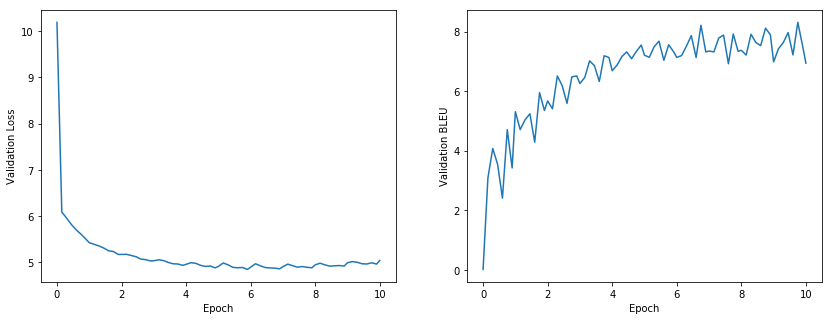

In [11]:
plot_single_learning_curve(experiment_results[0]['results'])

In [12]:
summarize_results(experiment_results)[['model_name', 'best_val_loss', 'best_val_bleu', 'runtime', 
                                       'total_params', 'trainable_params', 'dt_created']]

,model_name,best_val_loss,best_val_bleu,runtime,total_params,trainable_params,dt_created
0,zh-rnn-additive-attn-2018-12-12 05:40:57,4.847539,8.307246,770.818851,71591344,53591344,2018-12-12 18:31:51


In [ ]:
# reload model 
MODEL_NAME_TO_RELOAD = 'zh-rnn-additive-attn-2018-12-12 05:40:57'
checkpoint = torch.load('model_checkpoints/{}.pth.tar'.format(MODEL_NAME_TO_RELOAD), map_location=device)
model.load_state_dict(checkpoint)

In [ ]:
# check performance on validation set 
val_loss, val_bleu, val_hyp_idxs, val_ref_idxs, val_source_idxs, val_hyp_tokens, val_ref_tokens, val_source_tokens,\
val_attn = evaluate(model=model, loader=loaders_full['dev'], 
                    src_id2token=vocab[SRC_LANG]['id2token'], targ_id2token=vocab[TARG_LANG]['id2token'])
print("Validation BLEU: {:.2f} | Validation Loss: {:.2f}".format(val_bleu, val_loss))

In [ ]:
# evaluate on test set 
test_loss, test_bleu, test_hyp_idxs, test_ref_idxs, test_source_idxs, test_hyp_tokens, test_ref_tokens, test_source_tokens,\
test_attn = evaluate(model=model, loader=loaders_full['test'], 
                     src_id2token=vocab[SRC_LANG]['id2token'], targ_id2token=vocab[TARG_LANG]['id2token'])
print("Test BLEU: {:.2f} | Test Loss: {:.2f}".format(test_bleu, test_loss))